In [23]:
import matplotlib.pyplot as plt
import subprocess
import sys
sys.path.append("../")
from utils import createXYPlot
import pandas as pd
import numpy as np
df_vax = pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv")

In [24]:
df_vax.columns

Index(['data_somministrazione', 'fornitore', 'area', 'fascia_anagrafica',
       'sesso_maschile', 'sesso_femminile', 'prima_dose', 'seconda_dose',
       'pregressa_infezione', 'dose_addizionale_booster', 'codice_NUTS1',
       'codice_NUTS2', 'codice_regione_ISTAT', 'nome_area'],
      dtype='object')

In [25]:
fornitori = sorted(df_vax.fornitore.unique())
anagrafiche = sorted(df_vax.fascia_anagrafica.unique())

In [26]:
oggi = np.max(df_vax["data_somministrazione"])
plots_folder = f"./plots/{oggi}/vaccination"
print(plots_folder)
res = subprocess.check_output(f"mkdir -p {plots_folder}",shell=True)

./plots/2022-01-13/vaccination


In [27]:
def group_by_doses(df, keys, columns):
    agg_dict = {c:"sum" for c in columns}
    df = df.groupby(keys).agg(agg_dict).reset_index()
    return df

In [28]:
def get_grid(keys):
    grid = pd.DataFrame()
    for f in keys:
        new_grid = pd.DataFrame(df_vax[f].unique(), columns=[f])
        new_grid['key'] = 0
        grid['key'] = 0
        grid = grid.merge(new_grid, on='key', how='outer')
    grid = grid.sort_values(by=keys).reset_index(drop=True)
    return grid.drop(["key"],axis=1)

In [29]:
df_vax["terza_dose"] = df_vax["dose_addizionale_booster"]
df_vax["prima_dose_no_guariti"] = df_vax["prima_dose"]
df_vax["prima_dose"] = df_vax["prima_dose"] + df_vax["pregressa_infezione"]

In [30]:
cols_to_sum = ["prima_dose", "seconda_dose", "terza_dose", "pregressa_infezione", "prima_dose_no_guariti"]
df_vax_yyyy_mm_dd = group_by_doses(df_vax, keys=["data_somministrazione"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fornitore"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica", "fornitore"], columns=cols_to_sum)

In [31]:
pd.DataFrame(df_vax_yyyy_mm_dd[["prima_dose",
                                "seconda_dose",
                                "terza_dose",
                                "pregressa_infezione",
                                "prima_dose_no_guariti"
                               ]].agg(sum),columns=["totale"])

totale
prima_dose             49207254
seconda_dose           43745350
terza_dose             25435879
pregressa_infezione     1671236
prima_dose_no_guariti  47536018

In [32]:
def roll_mean(df, key=None):
    df = df.set_index("data_somministrazione")
    display(df)
    for dose in ["prima", "seconda", "terza"]:
        if key is not None:
            df_roll = pd.DataFrame(df.groupby(key)[f"{dose}_dose"].rolling(7).mean())
            df_roll = df_roll.rename(columns={f"{dose}_dose": f"{dose}_dose_media_7"})
            display(df_roll)
            for k in key:
                df = df.set_index(k, append=True)
            df = df.join(df_roll).reset_index().set_index("data_somministrazione")
            display(df)
        else:
            df[f"{dose}_dose_media_7"] = df[f"{dose}_dose"].rolling(7).mean()
    
    return df.reset_index()

In [33]:
df_vax_yyyy_mm_dd = roll_mean(df_vax_yyyy_mm_dd)
df_vax_yyyy_mm_dd_fornitore = roll_mean(df_vax_yyyy_mm_dd_fornitore,key=["fornitore"])
df_vax_yyyy_mm_dd_anag_fornitore = roll_mean(df_vax_yyyy_mm_dd_anag_fornitore,key=["fornitore","fascia_anagrafica"])
df_vax_yyyy_mm_dd_anag = roll_mean(df_vax_yyyy_mm_dd_anag, key=["fascia_anagrafica"])

prima_dose  seconda_dose  terza_dose  \
data_somministrazione                                         
2020-12-27                   7346             0           0   
2020-12-28                   1503             0           0   
2020-12-29                   1119             0           0   
2020-12-30                   4868             0           0   
2020-12-31                  25931             0           0   
...                           ...           ...         ...   
2022-01-09                  63947         37070      317044   
2022-01-10                  70382         54388      536478   
2022-01-11                  81662         54451      577092   
2022-01-12                  78042         50673      566374   
2022-01-13                  63103         49307      500945   

                       pregressa_infezione  prima_dose_no_guariti  
data_somministrazione                                              
2020-12-27                              15                   7331  
2020-12-28                               2                   1501  
2020-12-29                               1                   1118  
2020-12-30                               2                   4866  
2020-12-31                              34                  25897  
...                                    ...                    ...  
2022-01-09                            1120                  62827  
2022-01-10                            1725                  68657  
2022-01-11                            1829                  79833  
2022-01-12                            1776                  76266  
2022-01-13                            1608                  61495  

[383 rows x 5 columns]

fornitore  prima_dose  seconda_dose  \
data_somministrazione                                                
2020-12-27                       Moderna           1             0   
2020-12-27               Pfizer/BioNTech        7345             0   
2020-12-28                       Moderna           4             0   
2020-12-28               Pfizer/BioNTech        1499             0   
2020-12-29                       Moderna           3             0   
...                                  ...         ...           ...   
2022-01-12               Pfizer/BioNTech       22119         15751   
2022-01-13                       Janssen          29             0   
2022-01-13                       Moderna       18410         18217   
2022-01-13             Pfizer Pediatrico       25724         15731   
2022-01-13               Pfizer/BioNTech       18940         15359   

                       terza_dose  pregressa_infezione  prima_dose_no_guariti  
data_somministrazione                                                          
2020-12-27                      0                    0                      1  
2020-12-27                      0                   15                   7330  
2020-12-28                      0                    1                      3  
2020-12-28                      0                    1                   1498  
2020-12-29                      0                    0                      3  
...                           ...                  ...                    ...  
2022-01-12                 229754                  833                  21286  
2022-01-13                      0                    0                     29  
2022-01-13                 294505                  818                  17592  
2022-01-13                      0                   87                  25637  
2022-01-13                 206440                  703                  18237  

[1425 rows x 6 columns]

prima_dose_media_7
fornitore               data_somministrazione                    
Janssen                 2021-01-04                            NaN
                        2021-01-05                            NaN
                        2021-01-06                            NaN
                        2021-01-07                            NaN
                        2021-01-11                            NaN
...                                                           ...
Vaxzevria (AstraZeneca) 2021-12-19                       0.571429
                        2021-12-20                       0.714286
                        2021-12-30                       0.571429
                        2022-01-01                       0.571429
                        2022-01-11                       0.714286

[1425 rows x 1 columns]

fornitore  prima_dose  seconda_dose  \
data_somministrazione                                                
2020-12-27                       Moderna           1             0   
2020-12-27               Pfizer/BioNTech        7345             0   
2020-12-28                       Moderna           4             0   
2020-12-28               Pfizer/BioNTech        1499             0   
2020-12-29                       Moderna           3             0   
...                                  ...         ...           ...   
2022-01-12               Pfizer/BioNTech       22119         15751   
2022-01-13                       Janssen          29             0   
2022-01-13                       Moderna       18410         18217   
2022-01-13             Pfizer Pediatrico       25724         15731   
2022-01-13               Pfizer/BioNTech       18940         15359   

                       terza_dose  pregressa_infezione  prima_dose_no_guariti  \
data_somministrazione                                                           
2020-12-27                      0                    0                      1   
2020-12-27                      0                   15                   7330   
2020-12-28                      0                    1                      3   
2020-12-28                      0                    1                   1498   
2020-12-29                      0                    0                      3   
...                           ...                  ...                    ...   
2022-01-12                 229754                  833                  21286   
2022-01-13                      0                    0                     29   
2022-01-13                 294505                  818                  17592   
2022-01-13                      0                   87                  25637   
2022-01-13                 206440                  703                  18237   

                       prima_dose_media_7  
data_somministrazione                      
2020-12-27                            NaN  
2020-12-27                            NaN  
2020-12-28                            NaN  
2020-12-28                            NaN  
2020-12-29                            NaN  
...                                   ...  
2022-01-12                   17650.142857  
2022-01-13                     121.571429  
2022-01-13                   20680.428571  
2022-01-13                   33874.142857  
2022-01-13                   19239.857143  

[1425 rows x 7 columns]

seconda_dose_media_7
fornitore               data_somministrazione                      
Janssen                 2021-01-04                              NaN
                        2021-01-05                              NaN
                        2021-01-06                              NaN
                        2021-01-07                              NaN
                        2021-01-11                              NaN
...                                                             ...
Vaxzevria (AstraZeneca) 2021-12-19                         0.428571
                        2021-12-20                         0.428571
                        2021-12-30                         0.571429
                        2022-01-01                         0.571429
                        2022-01-11                         0.428571

[1425 rows x 1 columns]

fornitore  prima_dose  seconda_dose  \
data_somministrazione                                                
2020-12-27                       Moderna           1             0   
2020-12-27               Pfizer/BioNTech        7345             0   
2020-12-28                       Moderna           4             0   
2020-12-28               Pfizer/BioNTech        1499             0   
2020-12-29                       Moderna           3             0   
...                                  ...         ...           ...   
2022-01-12               Pfizer/BioNTech       22119         15751   
2022-01-13                       Janssen          29             0   
2022-01-13                       Moderna       18410         18217   
2022-01-13             Pfizer Pediatrico       25724         15731   
2022-01-13               Pfizer/BioNTech       18940         15359   

                       terza_dose  pregressa_infezione  prima_dose_no_guariti  \
data_somministrazione                                                           
2020-12-27                      0                    0                      1   
2020-12-27                      0                   15                   7330   
2020-12-28                      0                    1                      3   
2020-12-28                      0                    1                   1498   
2020-12-29                      0                    0                      3   
...                           ...                  ...                    ...   
2022-01-12                 229754                  833                  21286   
2022-01-13                      0                    0                     29   
2022-01-13                 294505                  818                  17592   
2022-01-13                      0                   87                  25637   
2022-01-13                 206440                  703                  18237   

                       prima_dose_media_7  seconda_dose_media_7  
data_somministrazione                                            
2020-12-27                            NaN                   NaN  
2020-12-27                            NaN                   NaN  
2020-12-28                            NaN                   NaN  
2020-12-28                            NaN                   NaN  
2020-12-29                            NaN                   NaN  
...                                   ...                   ...  
2022-01-12                   17650.142857          14231.571429  
2022-01-13                     121.571429              0.000000  
2022-01-13                   20680.428571          18725.714286  
2022-01-13                   33874.142857          16431.714286  
2022-01-13                   19239.857143          15608.571429  

[1425 rows x 8 columns]

terza_dose_media_7
fornitore               data_somministrazione                    
Janssen                 2021-01-04                            NaN
                        2021-01-05                            NaN
                        2021-01-06                            NaN
                        2021-01-07                            NaN
                        2021-01-11                            NaN
...                                                           ...
Vaxzevria (AstraZeneca) 2021-12-19                            0.0
                        2021-12-20                            0.0
                        2021-12-30                            0.0
                        2022-01-01                            0.0
                        2022-01-11                            0.0

[1425 rows x 1 columns]

fornitore  prima_dose  seconda_dose  \
data_somministrazione                                                
2020-12-27                       Moderna           1             0   
2020-12-27               Pfizer/BioNTech        7345             0   
2020-12-28                       Moderna           4             0   
2020-12-28               Pfizer/BioNTech        1499             0   
2020-12-29                       Moderna           3             0   
...                                  ...         ...           ...   
2022-01-12               Pfizer/BioNTech       22119         15751   
2022-01-13                       Janssen          29             0   
2022-01-13                       Moderna       18410         18217   
2022-01-13             Pfizer Pediatrico       25724         15731   
2022-01-13               Pfizer/BioNTech       18940         15359   

                       terza_dose  pregressa_infezione  prima_dose_no_guariti  \
data_somministrazione                                                           
2020-12-27                      0                    0                      1   
2020-12-27                      0                   15                   7330   
2020-12-28                      0                    1                      3   
2020-12-28                      0                    1                   1498   
2020-12-29                      0                    0                      3   
...                           ...                  ...                    ...   
2022-01-12                 229754                  833                  21286   
2022-01-13                      0                    0                     29   
2022-01-13                 294505                  818                  17592   
2022-01-13                      0                   87                  25637   
2022-01-13                 206440                  703                  18237   

                       prima_dose_media_7  seconda_dose_media_7  \
data_somministrazione                                             
2020-12-27                            NaN                   NaN   
2020-12-27                            NaN                   NaN   
2020-12-28                            NaN                   NaN   
2020-12-28                            NaN                   NaN   
2020-12-29                            NaN                   NaN   
...                                   ...                   ...   
2022-01-12                   17650.142857          14231.571429   
2022-01-13                     121.571429              0.000000   
2022-01-13                   20680.428571          18725.714286   
2022-01-13                   33874.142857          16431.714286   
2022-01-13                   19239.857143          15608.571429   

                       terza_dose_media_7  
data_somministrazione                      
2020-12-27                            NaN  
2020-12-27                            NaN  
2020-12-28                            NaN  
2020-12-28                            NaN  
2020-12-29                            NaN  
...                                   ...  
2022-01-12                  169331.000000  
2022-01-13                       0.000000  
2022-01-13                  319398.571429  
2022-01-13                       0.000000  
2022-01-13                  187450.571429  

[1425 rows x 9 columns]

fascia_anagrafica        fornitore  prima_dose  \
data_somministrazione                                                  
2020-12-27                        20-29  Pfizer/BioNTech         704   
2020-12-27                        30-39  Pfizer/BioNTech        1088   
2020-12-27                        40-49  Pfizer/BioNTech        1508   
2020-12-27                        50-59  Pfizer/BioNTech        2207   
2020-12-27                        60-69  Pfizer/BioNTech        1513   
...                                 ...              ...         ...   
2022-01-13                        70-79  Pfizer/BioNTech        1723   
2022-01-13                        80-89          Moderna         775   
2022-01-13                        80-89  Pfizer/BioNTech         914   
2022-01-13                          90+          Moderna         160   
2022-01-13                          90+  Pfizer/BioNTech         280   

                       seconda_dose  terza_dose  pregressa_infezione  \
data_somministrazione                                                  
2020-12-27                        0           0                    0   
2020-12-27                        0           0                    0   
2020-12-27                        0           0                    2   
2020-12-27                        0           0                    3   
2020-12-27                        0           0                    5   
...                             ...         ...                  ...   
2022-01-13                      979       22841                    6   
2022-01-13                      364        8583                    2   
2022-01-13                      459        7548                    2   
2022-01-13                       88        1706                    0   
2022-01-13                      127        1835                    3   

                       prima_dose_no_guariti  
data_somministrazione                         
2020-12-27                               704  
2020-12-27                              1088  
2020-12-27                              1506  
2020-12-27                              2204  
2020-12-27                              1508  
...                                      ...  
2022-01-13                              1717  
2022-01-13                               773  
2022-01-13                               912  
2022-01-13                               160  
2022-01-13                               277  

[11485 rows x 7 columns]

prima_dose_media_7
fornitore               fascia_anagrafica data_somministrazione                    
Janssen                 12-19             2021-01-11                            NaN
                                          2021-03-20                            NaN
                                          2021-04-06                            NaN
                                          2021-04-13                            NaN
                                          2021-04-25                            NaN
...                                                                             ...
Vaxzevria (AstraZeneca) 90+               2021-10-16                            0.0
                                          2021-10-21                            0.0
                                          2021-10-25                            0.0
                                          2021-10-27                            0.0
                                          2021-11-14                            0.0

[11485 rows x 1 columns]

fornitore fascia_anagrafica  prima_dose  \
data_somministrazione                                                  
2020-12-27             Pfizer/BioNTech             20-29         704   
2020-12-27             Pfizer/BioNTech             30-39        1088   
2020-12-27             Pfizer/BioNTech             40-49        1508   
2020-12-27             Pfizer/BioNTech             50-59        2207   
2020-12-27             Pfizer/BioNTech             60-69        1513   
...                                ...               ...         ...   
2022-01-13             Pfizer/BioNTech             70-79        1723   
2022-01-13                     Moderna             80-89         775   
2022-01-13             Pfizer/BioNTech             80-89         914   
2022-01-13                     Moderna               90+         160   
2022-01-13             Pfizer/BioNTech               90+         280   

                       seconda_dose  terza_dose  pregressa_infezione  \
data_somministrazione                                                  
2020-12-27                        0           0                    0   
2020-12-27                        0           0                    0   
2020-12-27                        0           0                    2   
2020-12-27                        0           0                    3   
2020-12-27                        0           0                    5   
...                             ...         ...                  ...   
2022-01-13                      979       22841                    6   
2022-01-13                      364        8583                    2   
2022-01-13                      459        7548                    2   
2022-01-13                       88        1706                    0   
2022-01-13                      127        1835                    3   

                       prima_dose_no_guariti  prima_dose_media_7  
data_somministrazione                                             
2020-12-27                               704                 NaN  
2020-12-27                              1088                 NaN  
2020-12-27                              1506                 NaN  
2020-12-27                              2204                 NaN  
2020-12-27                              1508                 NaN  
...                                      ...                 ...  
2022-01-13                              1717         1470.571429  
2022-01-13                               773          694.428571  
2022-01-13                               912          700.000000  
2022-01-13                               160          134.285714  
2022-01-13                               277          187.285714  

[11485 rows x 8 columns]

seconda_dose_media_7
fornitore               fascia_anagrafica data_somministrazione                      
Janssen                 12-19             2021-01-11                              NaN
                                          2021-03-20                              NaN
                                          2021-04-06                              NaN
                                          2021-04-13                              NaN
                                          2021-04-25                              NaN
...                                                                               ...
Vaxzevria (AstraZeneca) 90+               2021-10-16                         1.571429
                                          2021-10-21                         1.571429
                                          2021-10-25                         1.428571
                                          2021-10-27                         1.428571
                                          2021-11-14                         1.285714

[11485 rows x 1 columns]

fornitore fascia_anagrafica  prima_dose  \
data_somministrazione                                                  
2020-12-27             Pfizer/BioNTech             20-29         704   
2020-12-27             Pfizer/BioNTech             30-39        1088   
2020-12-27             Pfizer/BioNTech             40-49        1508   
2020-12-27             Pfizer/BioNTech             50-59        2207   
2020-12-27             Pfizer/BioNTech             60-69        1513   
...                                ...               ...         ...   
2022-01-13             Pfizer/BioNTech             70-79        1723   
2022-01-13                     Moderna             80-89         775   
2022-01-13             Pfizer/BioNTech             80-89         914   
2022-01-13                     Moderna               90+         160   
2022-01-13             Pfizer/BioNTech               90+         280   

                       seconda_dose  terza_dose  pregressa_infezione  \
data_somministrazione                                                  
2020-12-27                        0           0                    0   
2020-12-27                        0           0                    0   
2020-12-27                        0           0                    2   
2020-12-27                        0           0                    3   
2020-12-27                        0           0                    5   
...                             ...         ...                  ...   
2022-01-13                      979       22841                    6   
2022-01-13                      364        8583                    2   
2022-01-13                      459        7548                    2   
2022-01-13                       88        1706                    0   
2022-01-13                      127        1835                    3   

                       prima_dose_no_guariti  prima_dose_media_7  \
data_somministrazione                                              
2020-12-27                               704                 NaN   
2020-12-27                              1088                 NaN   
2020-12-27                              1506                 NaN   
2020-12-27                              2204                 NaN   
2020-12-27                              1508                 NaN   
...                                      ...                 ...   
2022-01-13                              1717         1470.571429   
2022-01-13                               773          694.428571   
2022-01-13                               912          700.000000   
2022-01-13                               160          134.285714   
2022-01-13                               277          187.285714   

                       seconda_dose_media_7  
data_somministrazione                        
2020-12-27                              NaN  
2020-12-27                              NaN  
2020-12-27                              NaN  
2020-12-27                              NaN  
2020-12-27                              NaN  
...                                     ...  
2022-01-13                       749.428571  
2022-01-13                       336.142857  
2022-01-13                       343.000000  
2022-01-13                        68.142857  
2022-01-13                        92.142857  

[11485 rows x 9 columns]

terza_dose_media_7
fornitore               fascia_anagrafica data_somministrazione                    
Janssen                 12-19             2021-01-11                            NaN
                                          2021-03-20                            NaN
                                          2021-04-06                            NaN
                                          2021-04-13                            NaN
                                          2021-04-25                            NaN
...                                                                             ...
Vaxzevria (AstraZeneca) 90+               2021-10-16                            0.0
                                          2021-10-21                            0.0
                                          2021-10-25                            0.0
                                          2021-10-27                            0.0
                                          2021-11-14                            0.0

[11485 rows x 1 columns]

fornitore fascia_anagrafica  prima_dose  \
data_somministrazione                                                  
2020-12-27             Pfizer/BioNTech             20-29         704   
2020-12-27             Pfizer/BioNTech             30-39        1088   
2020-12-27             Pfizer/BioNTech             40-49        1508   
2020-12-27             Pfizer/BioNTech             50-59        2207   
2020-12-27             Pfizer/BioNTech             60-69        1513   
...                                ...               ...         ...   
2022-01-13             Pfizer/BioNTech             70-79        1723   
2022-01-13                     Moderna             80-89         775   
2022-01-13             Pfizer/BioNTech             80-89         914   
2022-01-13                     Moderna               90+         160   
2022-01-13             Pfizer/BioNTech               90+         280   

                       seconda_dose  terza_dose  pregressa_infezione  \
data_somministrazione                                                  
2020-12-27                        0           0                    0   
2020-12-27                        0           0                    0   
2020-12-27                        0           0                    2   
2020-12-27                        0           0                    3   
2020-12-27                        0           0                    5   
...                             ...         ...                  ...   
2022-01-13                      979       22841                    6   
2022-01-13                      364        8583                    2   
2022-01-13                      459        7548                    2   
2022-01-13                       88        1706                    0   
2022-01-13                      127        1835                    3   

                       prima_dose_no_guariti  prima_dose_media_7  \
data_somministrazione                                              
2020-12-27                               704                 NaN   
2020-12-27                              1088                 NaN   
2020-12-27                              1506                 NaN   
2020-12-27                              2204                 NaN   
2020-12-27                              1508                 NaN   
...                                      ...                 ...   
2022-01-13                              1717         1470.571429   
2022-01-13                               773          694.428571   
2022-01-13                               912          700.000000   
2022-01-13                               160          134.285714   
2022-01-13                               277          187.285714   

                       seconda_dose_media_7  terza_dose_media_7  
data_somministrazione                                            
2020-12-27                              NaN                 NaN  
2020-12-27                              NaN                 NaN  
2020-12-27                              NaN                 NaN  
2020-12-27                              NaN                 NaN  
2020-12-27                              NaN                 NaN  
...                                     ...                 ...  
2022-01-13                       749.428571        19276.857143  
2022-01-13                       336.142857         8699.571429  
2022-01-13                       343.000000         6167.571429  
2022-01-13                        68.142857         1590.000000  
2022-01-13                        92.142857         1434.142857  

[11485 rows x 10 columns]

fascia_anagrafica  prima_dose  seconda_dose  terza_dose  \
data_somministrazione                                                           
2020-12-27                        20-29         704             0           0   
2020-12-27                        30-39        1088             0           0   
2020-12-27                        40-49        1508             0           0   
2020-12-27                        50-59        2207             0           0   
2020-12-27                        60-69        1513             0           0   
...                                 ...         ...           ...         ...   
2022-01-13                        50-59        7359          5028       99551   
2022-01-13                        60-69        5855          3610       78210   
2022-01-13                        70-79        3523          2107       55393   
2022-01-13                        80-89        1689           823       16131   
2022-01-13                          90+         440           215        3541   

                       pregressa_infezione  prima_dose_no_guariti  
data_somministrazione                                              
2020-12-27                               0                    704  
2020-12-27                               0                   1088  
2020-12-27                               2                   1506  
2020-12-27                               3                   2204  
2020-12-27                               5                   1508  
...                                    ...                    ...  
2022-01-13                             171                   7188  
2022-01-13                              62                   5793  
2022-01-13                              18                   3505  
2022-01-13                               4                   1685  
2022-01-13                               3                    437  

[3471 rows x 6 columns]

prima_dose_media_7
fascia_anagrafica data_somministrazione                    
05-11             2021-12-15                            NaN
                  2021-12-16                            NaN
                  2021-12-17                            NaN
                  2021-12-18                            NaN
                  2021-12-19                            NaN
...                                                     ...
90+               2022-01-09                     176.428571
                  2022-01-10                     194.857143
                  2022-01-11                     229.428571
                  2022-01-12                     268.000000
                  2022-01-13                     321.571429

[3471 rows x 1 columns]

fascia_anagrafica  prima_dose  seconda_dose  terza_dose  \
data_somministrazione                                                           
2020-12-27                        20-29         704             0           0   
2020-12-27                        30-39        1088             0           0   
2020-12-27                        40-49        1508             0           0   
2020-12-27                        50-59        2207             0           0   
2020-12-27                        60-69        1513             0           0   
...                                 ...         ...           ...         ...   
2022-01-13                        50-59        7359          5028       99551   
2022-01-13                        60-69        5855          3610       78210   
2022-01-13                        70-79        3523          2107       55393   
2022-01-13                        80-89        1689           823       16131   
2022-01-13                          90+         440           215        3541   

                       pregressa_infezione  prima_dose_no_guariti  \
data_somministrazione                                               
2020-12-27                               0                    704   
2020-12-27                               0                   1088   
2020-12-27                               2                   1506   
2020-12-27                               3                   2204   
2020-12-27                               5                   1508   
...                                    ...                    ...   
2022-01-13                             171                   7188   
2022-01-13                              62                   5793   
2022-01-13                              18                   3505   
2022-01-13                               4                   1685   
2022-01-13                               3                    437   

                       prima_dose_media_7  
data_somministrazione                      
2020-12-27                            NaN  
2020-12-27                            NaN  
2020-12-27                            NaN  
2020-12-27                            NaN  
2020-12-27                            NaN  
...                                   ...  
2022-01-13                    7448.285714  
2022-01-13                    5643.285714  
2022-01-13                    3286.285714  
2022-01-13                    1394.714286  
2022-01-13                     321.571429  

[3471 rows x 7 columns]

seconda_dose_media_7
fascia_anagrafica data_somministrazione                      
05-11             2021-12-15                              NaN
                  2021-12-16                              NaN
                  2021-12-17                              NaN
                  2021-12-18                              NaN
                  2021-12-19                              NaN
...                                                       ...
90+               2022-01-09                       122.142857
                  2022-01-10                       124.857143
                  2022-01-11                       130.857143
                  2022-01-12                       136.571429
                  2022-01-13                       160.285714

[3471 rows x 1 columns]

fascia_anagrafica  prima_dose  seconda_dose  terza_dose  \
data_somministrazione                                                           
2020-12-27                        20-29         704             0           0   
2020-12-27                        30-39        1088             0           0   
2020-12-27                        40-49        1508             0           0   
2020-12-27                        50-59        2207             0           0   
2020-12-27                        60-69        1513             0           0   
...                                 ...         ...           ...         ...   
2022-01-13                        50-59        7359          5028       99551   
2022-01-13                        60-69        5855          3610       78210   
2022-01-13                        70-79        3523          2107       55393   
2022-01-13                        80-89        1689           823       16131   
2022-01-13                          90+         440           215        3541   

                       pregressa_infezione  prima_dose_no_guariti  \
data_somministrazione                                               
2020-12-27                               0                    704   
2020-12-27                               0                   1088   
2020-12-27                               2                   1506   
2020-12-27                               3                   2204   
2020-12-27                               5                   1508   
...                                    ...                    ...   
2022-01-13                             171                   7188   
2022-01-13                              62                   5793   
2022-01-13                              18                   3505   
2022-01-13                               4                   1685   
2022-01-13                               3                    437   

                       prima_dose_media_7  seconda_dose_media_7  
data_somministrazione                                            
2020-12-27                            NaN                   NaN  
2020-12-27                            NaN                   NaN  
2020-12-27                            NaN                   NaN  
2020-12-27                            NaN                   NaN  
2020-12-27                            NaN                   NaN  
...                                   ...                   ...  
2022-01-13                    7448.285714           4963.857143  
2022-01-13                    5643.285714           3084.285714  
2022-01-13                    3286.285714           1682.142857  
2022-01-13                    1394.714286            679.142857  
2022-01-13                     321.571429            160.285714  

[3471 rows x 8 columns]

terza_dose_media_7
fascia_anagrafica data_somministrazione                    
05-11             2021-12-15                            NaN
                  2021-12-16                            NaN
                  2021-12-17                            NaN
                  2021-12-18                            NaN
                  2021-12-19                            NaN
...                                                     ...
90+               2022-01-09                    2789.428571
                  2022-01-10                    2774.285714
                  2022-01-11                    2723.428571
                  2022-01-12                    2695.000000
                  2022-01-13                    3024.142857

[3471 rows x 1 columns]

fascia_anagrafica  prima_dose  seconda_dose  terza_dose  \
data_somministrazione                                                           
2020-12-27                        20-29         704             0           0   
2020-12-27                        30-39        1088             0           0   
2020-12-27                        40-49        1508             0           0   
2020-12-27                        50-59        2207             0           0   
2020-12-27                        60-69        1513             0           0   
...                                 ...         ...           ...         ...   
2022-01-13                        50-59        7359          5028       99551   
2022-01-13                        60-69        5855          3610       78210   
2022-01-13                        70-79        3523          2107       55393   
2022-01-13                        80-89        1689           823       16131   
2022-01-13                          90+         440           215        3541   

                       pregressa_infezione  prima_dose_no_guariti  \
data_somministrazione                                               
2020-12-27                               0                    704   
2020-12-27                               0                   1088   
2020-12-27                               2                   1506   
2020-12-27                               3                   2204   
2020-12-27                               5                   1508   
...                                    ...                    ...   
2022-01-13                             171                   7188   
2022-01-13                              62                   5793   
2022-01-13                              18                   3505   
2022-01-13                               4                   1685   
2022-01-13                               3                    437   

                       prima_dose_media_7  seconda_dose_media_7  \
data_somministrazione                                             
2020-12-27                            NaN                   NaN   
2020-12-27                            NaN                   NaN   
2020-12-27                            NaN                   NaN   
2020-12-27                            NaN                   NaN   
2020-12-27                            NaN                   NaN   
...                                   ...                   ...   
2022-01-13                    7448.285714           4963.857143   
2022-01-13                    5643.285714           3084.285714   
2022-01-13                    3286.285714           1682.142857   
2022-01-13                    1394.714286            679.142857   
2022-01-13                     321.571429            160.285714   

                       terza_dose_media_7  
data_somministrazione                      
2020-12-27                            NaN  
2020-12-27                            NaN  
2020-12-27                            NaN  
2020-12-27                            NaN  
2020-12-27                            NaN  
...                                   ...  
2022-01-13                  106082.714286  
2022-01-13                   80508.000000  
2022-01-13                   54089.000000  
2022-01-13                   14867.142857  
2022-01-13                    3024.142857  

[3471 rows x 9 columns]

In [34]:
fornitori = df_vax_yyyy_mm_dd_fornitore["fornitore"].unique()

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


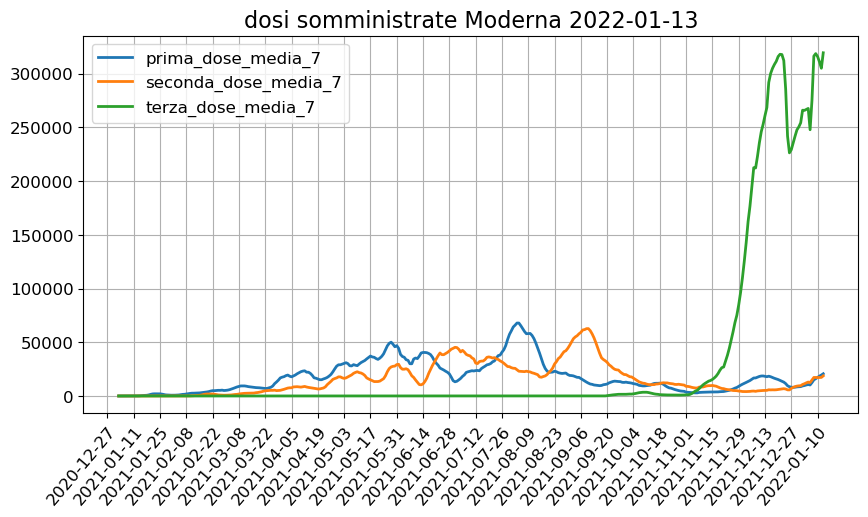

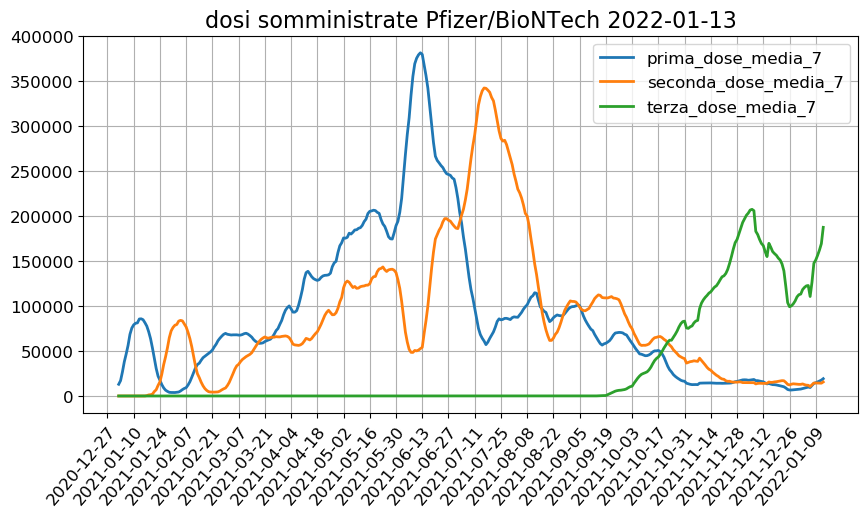

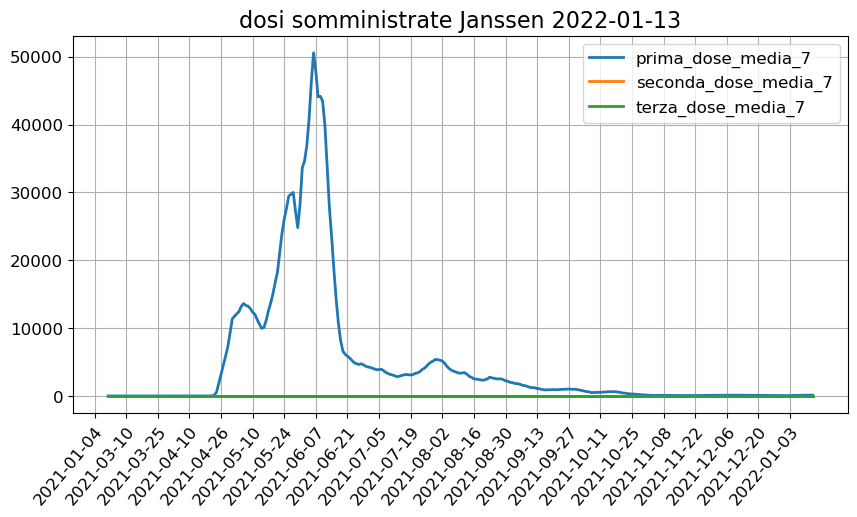

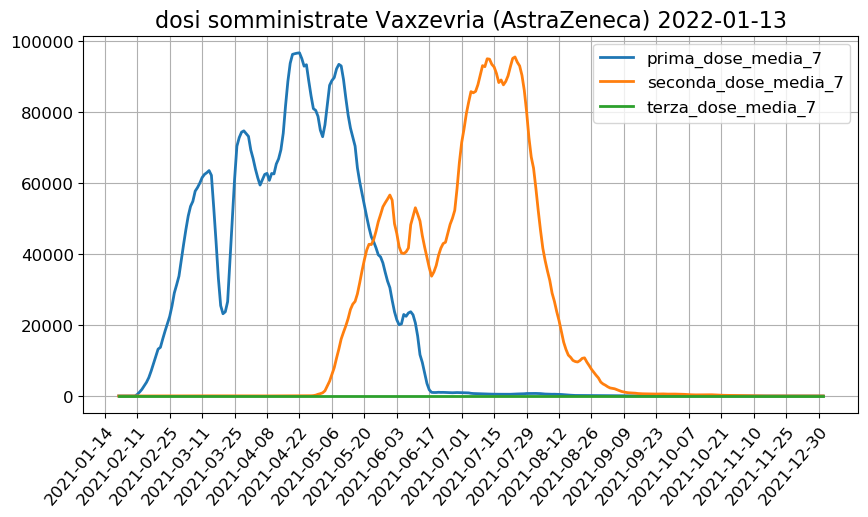

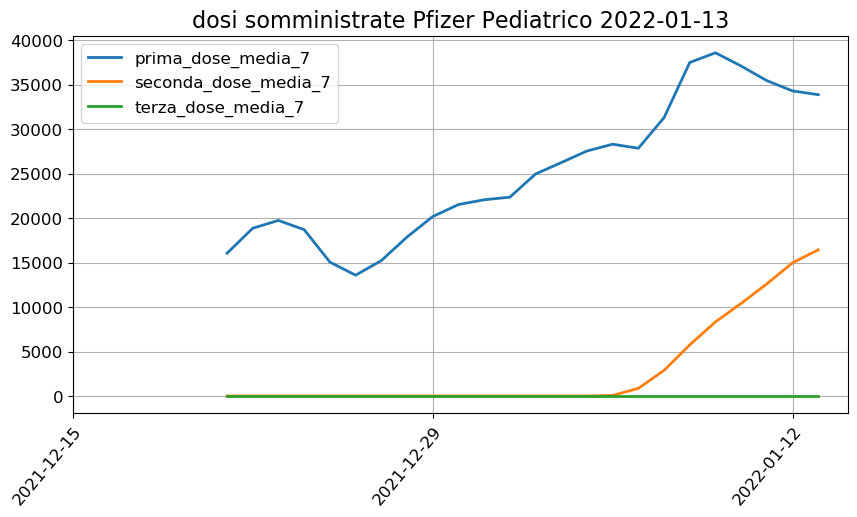

In [35]:
for fornitore in fornitori:
    savename_suffix="_"+fornitore.replace("/","_")
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    df_plot["prima_dose_media_7"] = df_plot["prima_dose"].rolling(7).mean()
    df_plot["seconda_dose_media_7"] = df_plot["seconda_dose"].rolling(7).mean()
    df_plot["terza_dose_media_7"] = df_plot["terza_dose"].rolling(7).mean()
    createXYPlot(df_plot, 
                 y=["prima_dose_media_7","seconda_dose_media_7","terza_dose_media_7"], 
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"dosi somministrate {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")

In [36]:
df_vax_yyyy_mm_dd.tail(15)

data_somministrazione  prima_dose  seconda_dose  terza_dose  \
368            2021-12-30       56073         26923      497786   
369            2021-12-31       21542         11828      246653   
370            2022-01-01        5403          2968       64595   
371            2022-01-02       43735         18715      275936   
372            2022-01-03       66262         41221      519201   
373            2022-01-04       77256         39211      570423   
374            2022-01-05       72323         33699      558225   
375            2022-01-06       46618         19448      273534   
376            2022-01-07       76610         56271      550697   
377            2022-01-08       83667         53202      499314   
378            2022-01-09       63947         37070      317044   
379            2022-01-10       70382         54388      536478   
380            2022-01-11       81662         54451      577092   
381            2022-01-12       78042         50673      566374   
382            2022-01-13       63103         49307      500945   

     pregressa_infezione  prima_dose_no_guariti  prima_dose_media_7  \
368                  674                  55399        37392.428571   
369                  298                  21244        38286.857143   
370                   86                   5317        38821.000000   
371                  684                  43051        42636.714286   
372                 1420                  64842        44898.428571   
373                 1540                  75716        47326.000000   
374                 1481                  70842        48942.000000   
375                  869                  45749        47591.285714   
376                 1684                  74926        55458.142857   
377                 1496                  82171        66638.714286   
378                 1120                  62827        69526.142857   
379                 1725                  68657        70114.714286   
380                 1829                  79833        70744.142857   
381                 1776                  76266        71561.142857   
382                 1608                  61495        73916.142857   

     seconda_dose_media_7  terza_dose_media_7  
368          22340.714286       357823.428571  
369          22355.571429       363020.571429  
370          22501.142857       367542.571429  
371          24108.428571       384272.428571  
372          23971.714286       386522.000000  
373          24271.285714       389063.857143  
374          24937.857143       390402.714286  
375          23870.000000       358366.714286  
376          30219.000000       401801.571429  
377          37395.285714       463904.285714  
378          40017.428571       469776.857143  
379          41898.428571       472245.000000  
380          44075.571429       473197.714286  
381          46500.428571       474361.857143  
382          50766.000000       506849.142857

In [37]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [38]:
df_vax_yyyy_mm_dd

data_somministrazione  prima_dose  seconda_dose  terza_dose  \
0              2020-12-27        7346             0           0   
1              2020-12-28        1503             0           0   
2              2020-12-29        1119             0           0   
3              2020-12-30        4868             0           0   
4              2020-12-31       25931             0           0   
..                    ...         ...           ...         ...   
378            2022-01-09       63947         37070      317044   
379            2022-01-10       70382         54388      536478   
380            2022-01-11       81662         54451      577092   
381            2022-01-12       78042         50673      566374   
382            2022-01-13       63103         49307      500945   

     pregressa_infezione  prima_dose_no_guariti  prima_dose_media_7  \
0                     15                   7331                 NaN   
1                      2                   1501                 NaN   
2                      1                   1118                 NaN   
3                      2                   4866                 NaN   
4                     34                  25897                 NaN   
..                   ...                    ...                 ...   
378                 1120                  62827        69526.142857   
379                 1725                  68657        70114.714286   
380                 1829                  79833        70744.142857   
381                 1776                  76266        71561.142857   
382                 1608                  61495        73916.142857   

     seconda_dose_media_7  terza_dose_media_7  
0                     NaN                 NaN  
1                     NaN                 NaN  
2                     NaN                 NaN  
3                     NaN                 NaN  
4                     NaN                 NaN  
..                    ...                 ...  
378          40017.428571       469776.857143  
379          41898.428571       472245.000000  
380          44075.571429       473197.714286  
381          46500.428571       474361.857143  
382          50766.000000       506849.142857  

[383 rows x 9 columns]

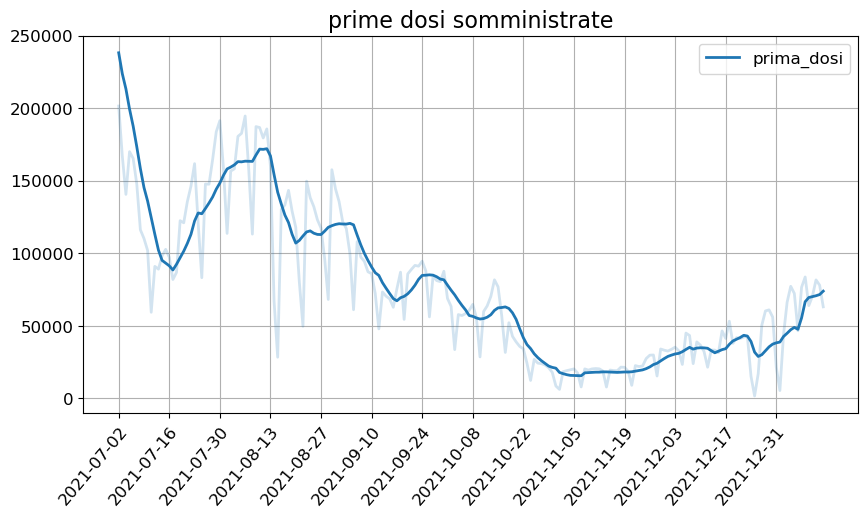

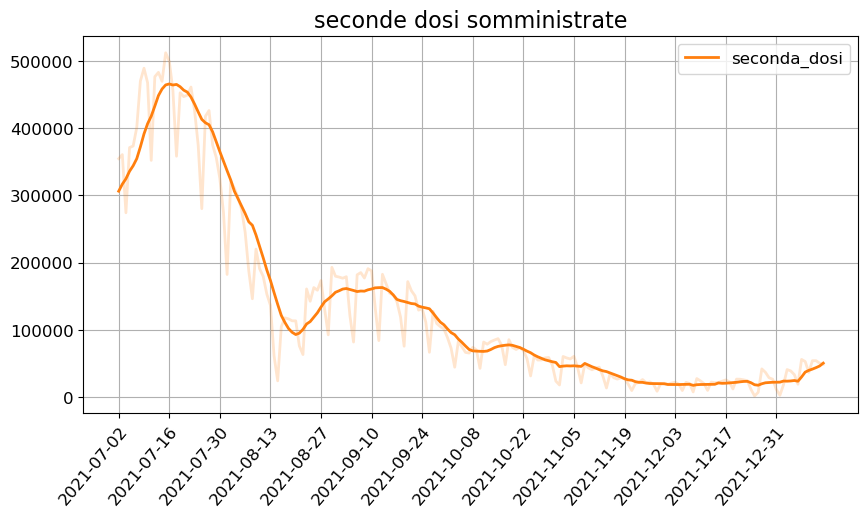

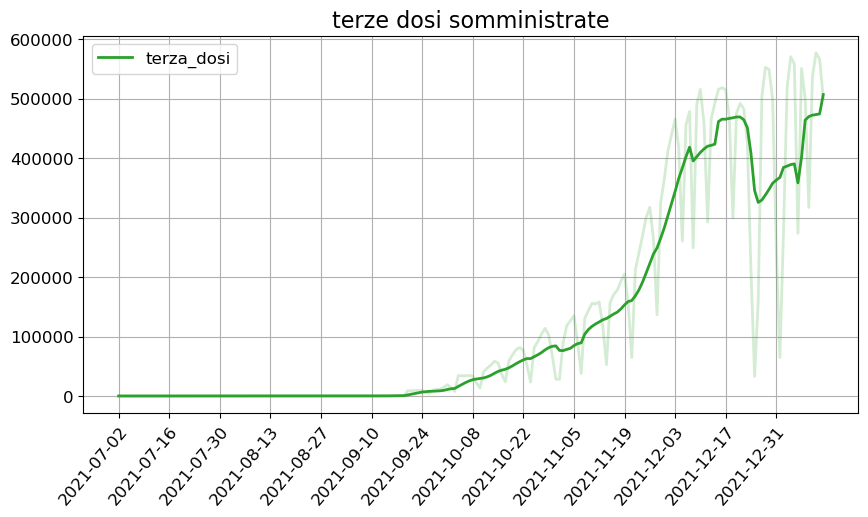

In [41]:
i = 0
for dose in ["prima","seconda","terza"]:
    
    createXYPlot(df_vax_yyyy_mm_dd, 
                 y=[f"{dose}_dose",f"{dose}_dose_media_7"], 
                 labels=[None, f"{dose}_dosi"],
                 colors=[colors[i],colors[i]],
                 alphas=[0.2,1],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 start_date="2021-07-01",
                 title=f"{dose.replace('a','e')} dosi somministrate",
                 plots_folder=plots_folder,
                 savename=f"{dose.replace('a','e')}_dosi_somministrate.png"
                )
    i +=1

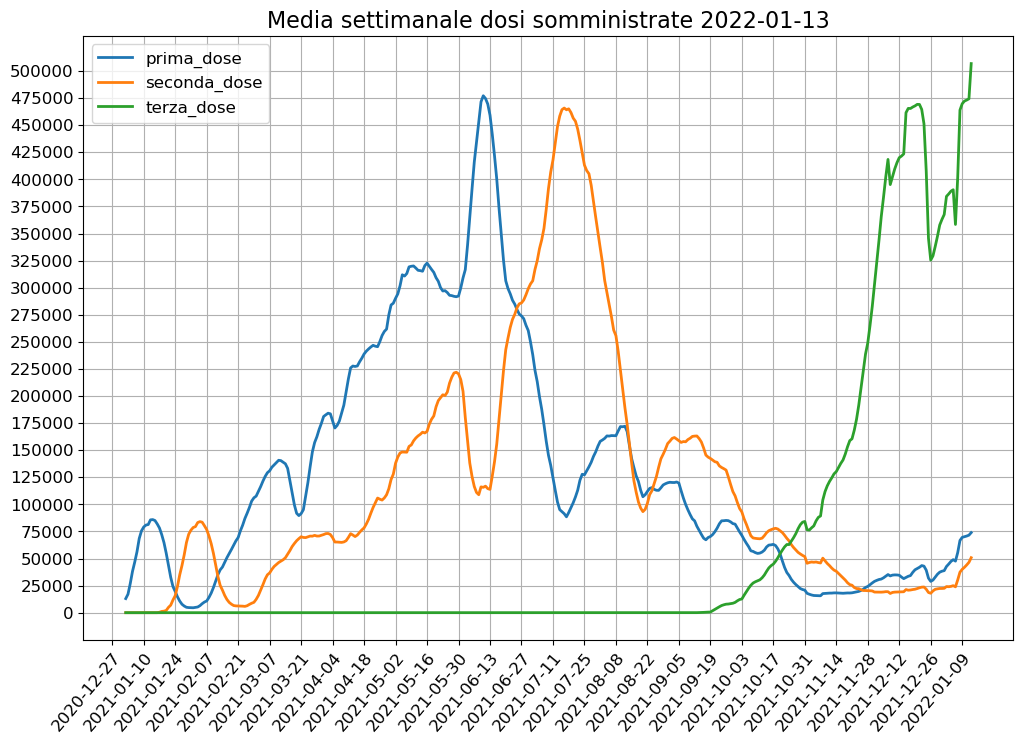

In [42]:
createXYPlot(df_vax_yyyy_mm_dd, 
                 y=["prima_dose_media_7","seconda_dose_media_7","terza_dose_media_7"], 
                 labels=["prima_dose", "seconda_dose", "terza_dose"],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"Media settimanale dosi somministrate {oggi}",
                 plots_folder=plots_folder,
                 yticks=range(0,525000,25000),
                 figsize_x=12,
                 figsize_y=8,
                 savename=f"dosi_somministrate_media7.png")

In [43]:
df_vax_yyyy_mm_dd["totale_prima_dose"] = df_vax_yyyy_mm_dd["prima_dose"].cumsum()
df_vax_yyyy_mm_dd["totale_seconda_dose"] = df_vax_yyyy_mm_dd["seconda_dose"].cumsum()
df_vax_yyyy_mm_dd["totale_terza_dose"] = df_vax_yyyy_mm_dd["terza_dose"].cumsum()

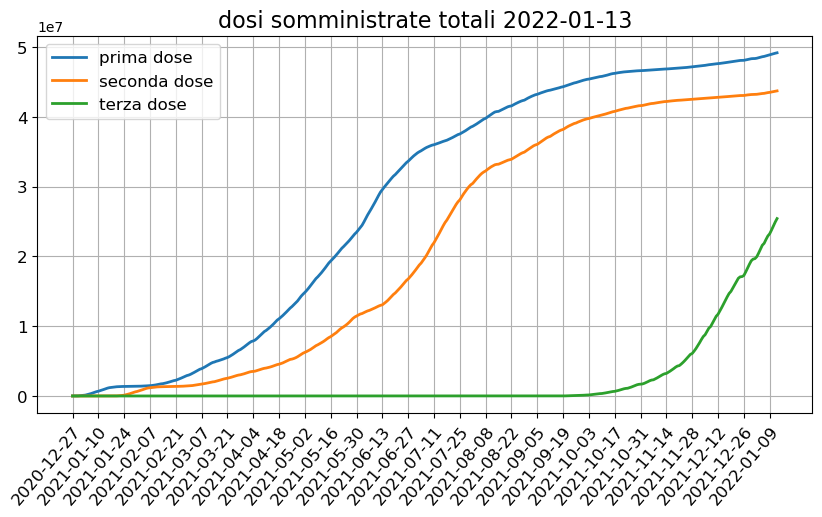

In [44]:
createXYPlot(df_vax_yyyy_mm_dd, 
             y=["totale_prima_dose","totale_seconda_dose", "totale_terza_dose"], 
             labels=["prima dose", "seconda dose", "terza dose"],
             x="data_somministrazione", 
             days_interval=14,
             linewidth=2,
             title=f"dosi somministrate totali {oggi}",
             plots_folder=plots_folder,
             savename=f"dosi_somministrate_cumulativo.png"
            )

### Cumulativa per fornitore

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


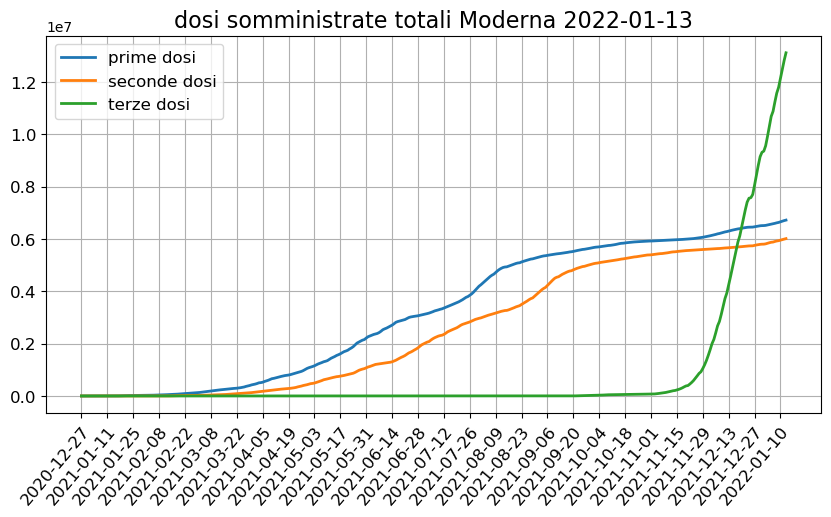

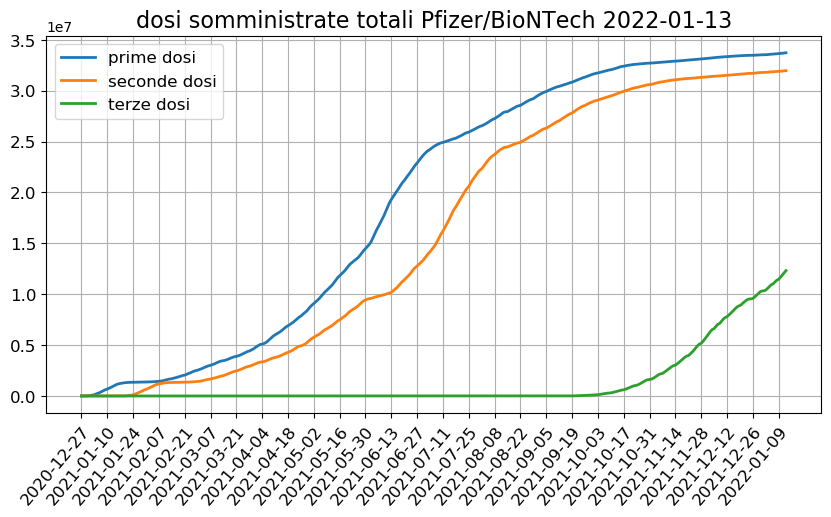

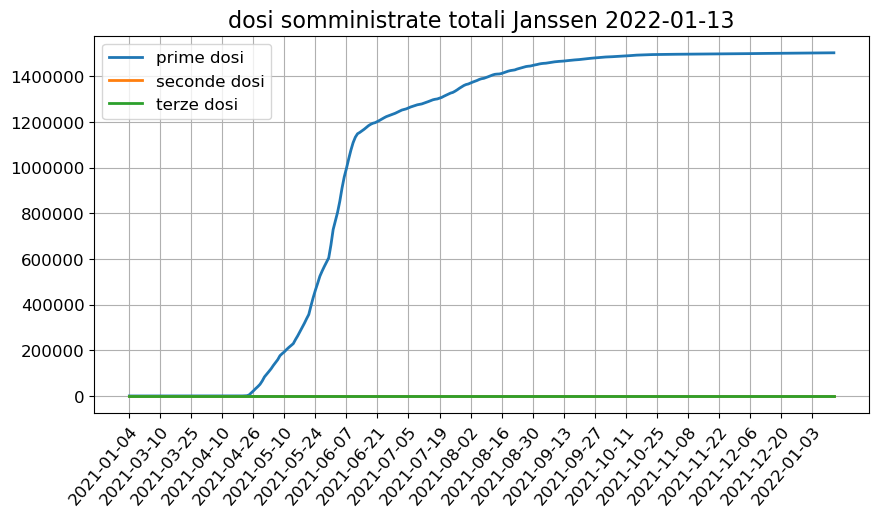

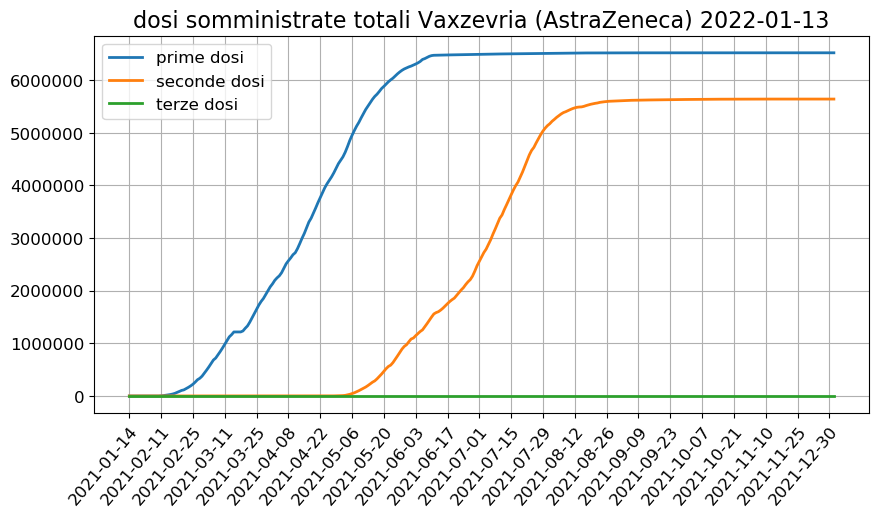

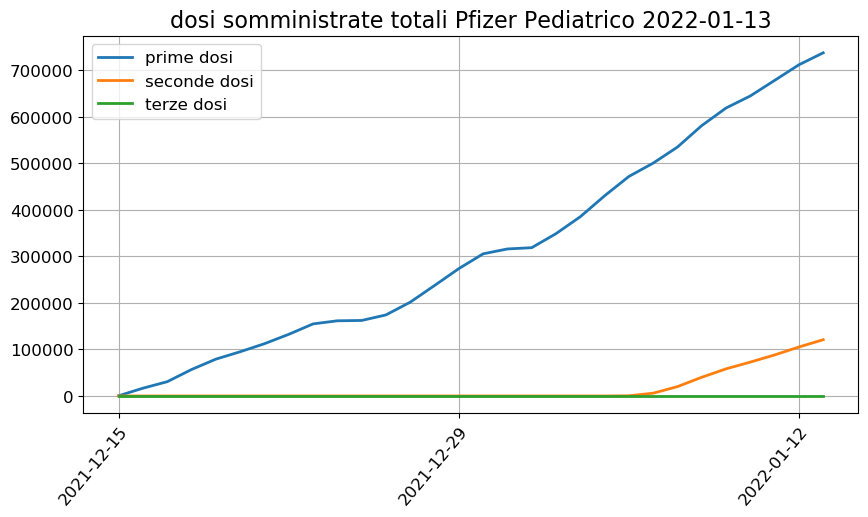

In [45]:
for fornitore in fornitori:
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    df_plot["totale_prima_dose"] = df_plot["prima_dose"].cumsum()
    df_plot["totale_seconda_dose"] = df_plot["seconda_dose"].cumsum()
    df_plot["totale_terza_dose"] = df_plot["terza_dose"].cumsum()
    savename_suffix="_"+fornitore.replace("/","_")    
    createXYPlot(df_plot, 
                 y=["totale_prima_dose","totale_seconda_dose","totale_terza_dose"],
                 labels=["prime dosi","seconde dosi", "terze dosi"],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"dosi somministrate totali {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate_totali_{savename_suffix}.png")

In [22]:
df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag["fascia_anagrafica"]=="05-11"].tail(3)

data_somministrazione fascia_anagrafica  prima_dose  seconda_dose  \
3441            2022-01-11             05-11       33404         15352   
3451            2022-01-12             05-11       33559         17058   
3461            2022-01-13             05-11       25724         15731   

      terza_dose  pregressa_infezione  prima_dose_no_guariti  \
3441           0                  103                  33301   
3451           0                   91                  33468   
3461           0                   87                  25637   

      prima_dose_media_7  seconda_dose_media_7  terza_dose_media_7  
3441        35449.142857          12602.857143                 0.0  
3451        34293.142857          14977.000000                 0.0  
3461        33874.142857          16431.714286                 0.0

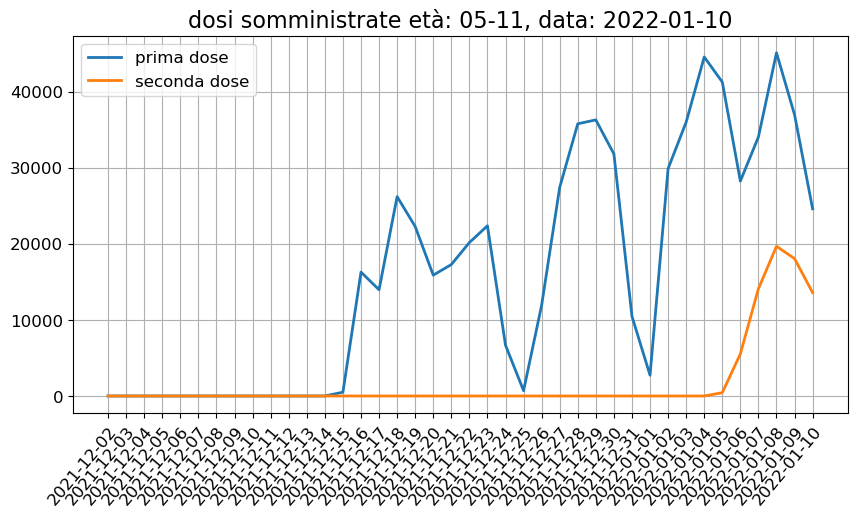

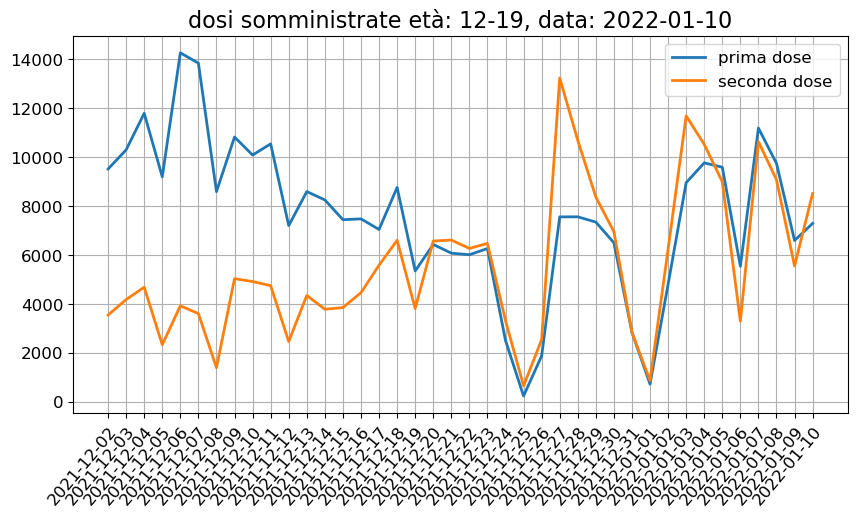

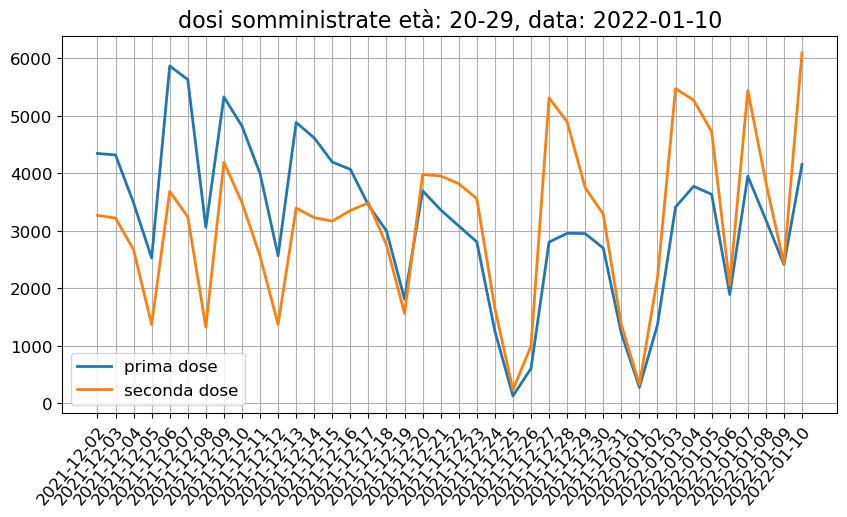

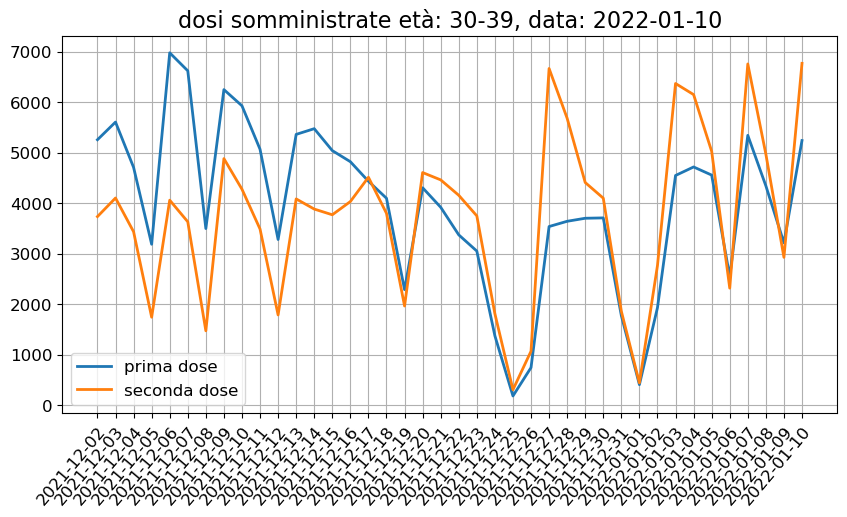

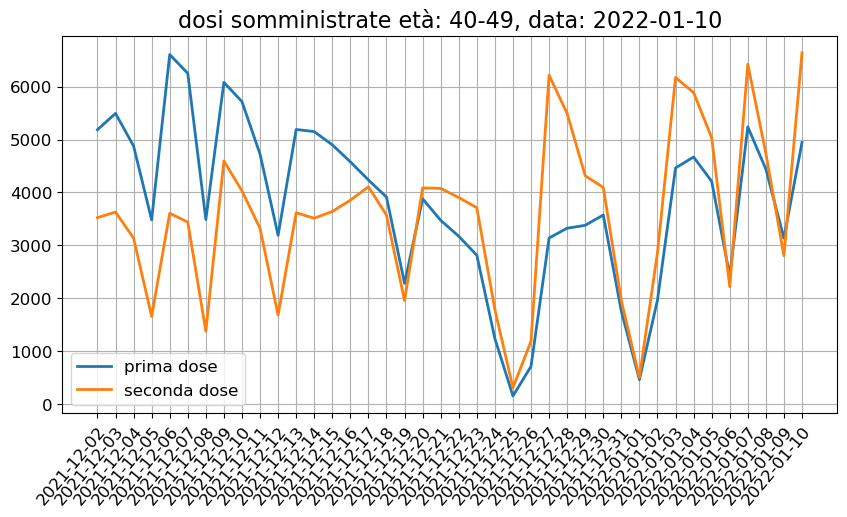

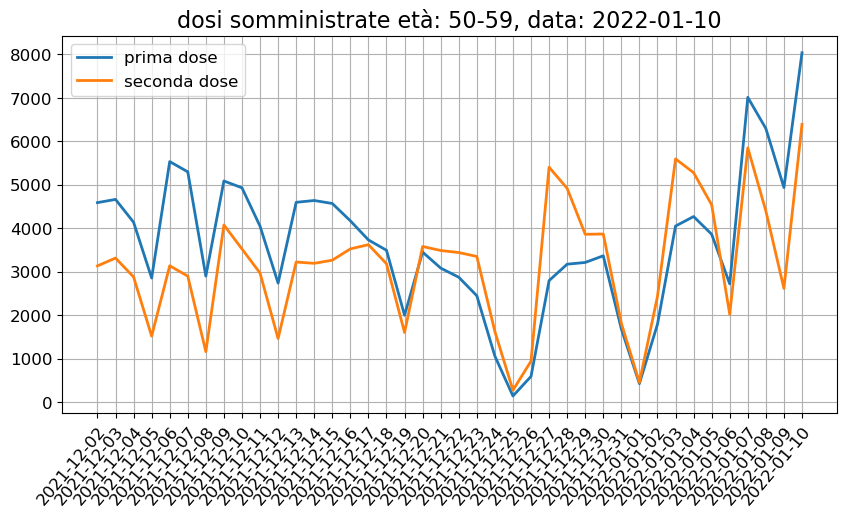

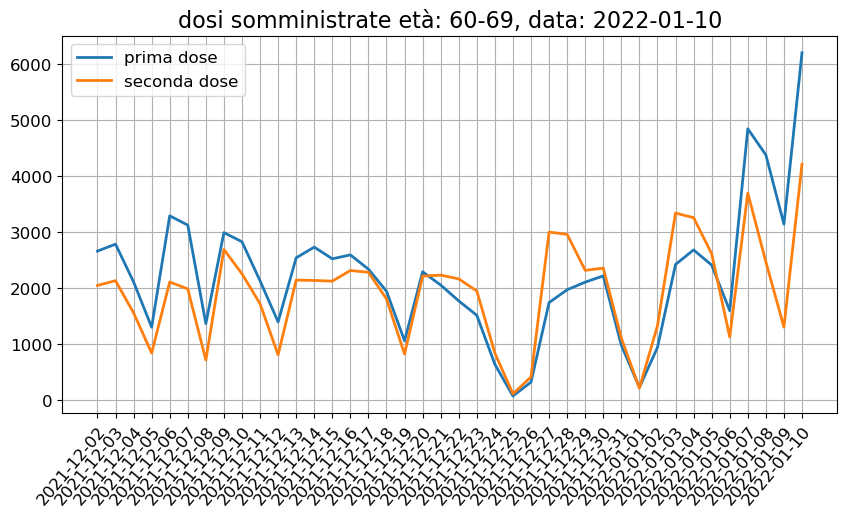

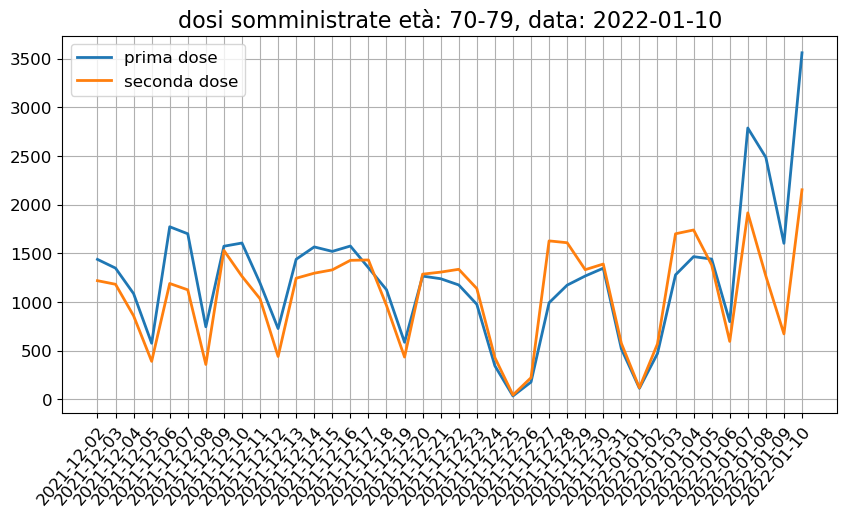

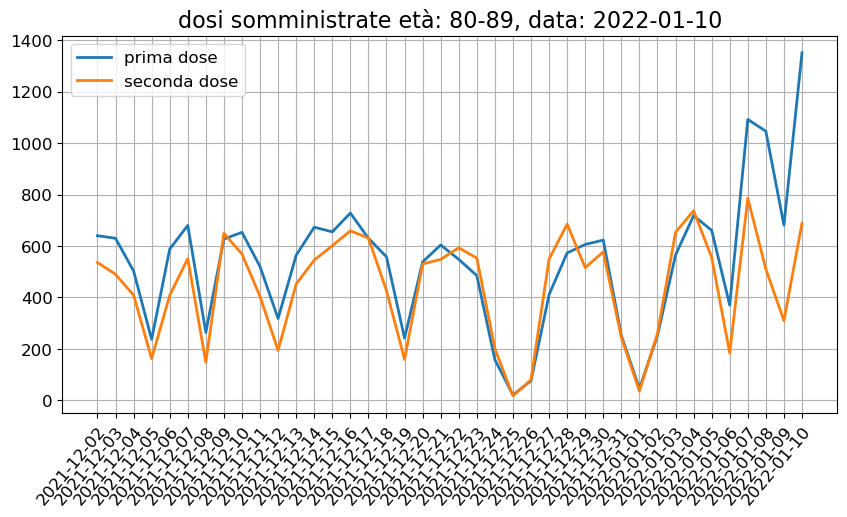

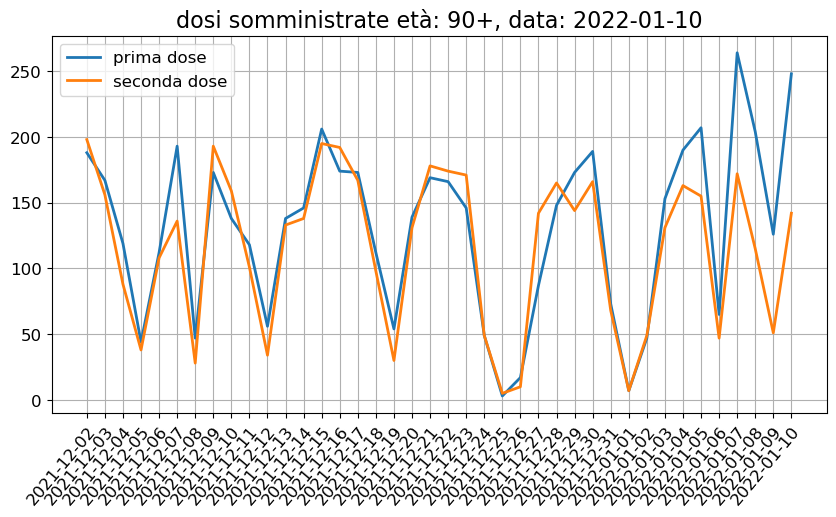

In [37]:
for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
    savename_suffix="_" + anag  
    df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    createXYPlot(df_plot, 
                 y=["prima_dose","seconda_dose"], 
                 labels=["prima dose", "seconda dose"],
                 x="data_somministrazione", 
                 linewidth=2,
                 days_interval=1,
                 start_date="2021-12-01",
                 title=f"dosi somministrate età: {anag}, data: {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")


In [46]:
grid = get_grid(keys=["data_somministrazione","fascia_anagrafica"])

In [47]:
df_vax_yyyy_mm_dd_anag = grid.merge(df_vax_yyyy_mm_dd_anag, on=["data_somministrazione","fascia_anagrafica"], how="left")
df_vax_yyyy_mm_dd_anag = df_vax_yyyy_mm_dd_anag.fillna(0)

In [48]:
df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.data_somministrazione=="2020-12-27"]

data_somministrazione fascia_anagrafica  prima_dose  seconda_dose  \
0            2020-12-27             05-11         0.0           0.0   
1            2020-12-27             12-19         0.0           0.0   
2            2020-12-27             20-29       704.0           0.0   
3            2020-12-27             30-39      1088.0           0.0   
4            2020-12-27             40-49      1508.0           0.0   
5            2020-12-27             50-59      2207.0           0.0   
6            2020-12-27             60-69      1513.0           0.0   
7            2020-12-27             70-79       130.0           0.0   
8            2020-12-27             80-89       118.0           0.0   
9            2020-12-27               90+        78.0           0.0   

   terza_dose  pregressa_infezione  prima_dose_no_guariti  prima_dose_media_7  \
0         0.0                  0.0                    0.0                 0.0   
1         0.0                  0.0                    0.0                 0.0   
2         0.0                  0.0                  704.0                 0.0   
3         0.0                  0.0                 1088.0                 0.0   
4         0.0                  2.0                 1506.0                 0.0   
5         0.0                  3.0                 2204.0                 0.0   
6         0.0                  5.0                 1508.0                 0.0   
7         0.0                  2.0                  128.0                 0.0   
8         0.0                  1.0                  117.0                 0.0   
9         0.0                  2.0                   76.0                 0.0   

   seconda_dose_media_7  terza_dose_media_7  
0                   0.0                 0.0  
1                   0.0                 0.0  
2                   0.0                 0.0  
3                   0.0                 0.0  
4                   0.0                 0.0  
5                   0.0                 0.0  
6                   0.0                 0.0  
7                   0.0                 0.0  
8                   0.0                 0.0  
9                   0.0                 0.0

In [49]:
def dosi_eta(media=True):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for dose in ["prima","seconda","terza"]:
        plt.figure(dpi=100,figsize=(11,5))
        col_idx = 0
        for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
            df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
            df_plot = df_plot[df_plot.data_somministrazione>='2021-10-01']
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % 7 == 0]
            if media:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=0.2, color=colors[col_idx])
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose_media_7"], label=anag, color=colors[col_idx], linewidth=2.0)
            else:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=1, label=anag, color=colors[col_idx])

            col_idx +=1
        plt.xticks(x, rotation=60, 
                   rotation_mode="anchor", 
                   verticalalignment = "top", 
                   horizontalalignment = "right",
                   fontsize=12
                  )
        plt.yticks(fontsize=12)
        plt.grid()
        plt.legend()
        if dose == "prima":
            title = "Prime dosi"
        elif dose == "seconda":
            title = "Seconde dosi"
        else:
            title = "Terze dosi"
        plt.title(f"{title} somministrate per fascia d'età",fontsize=16)
        savename=f"{plots_folder}/{dose}_dose_fascia_eta"
        if media:
            savename += "_media"
        plt.savefig(fname=f"{savename}.png",bbox_inches="tight")

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


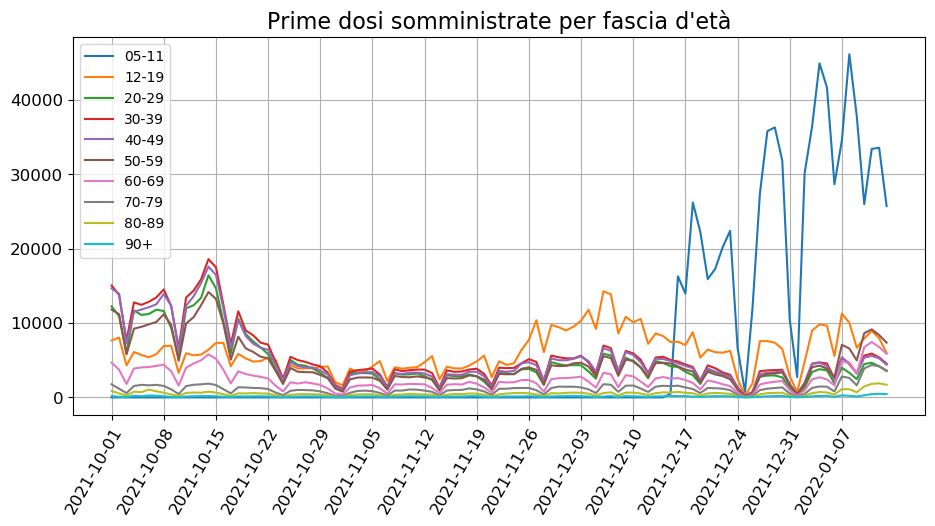

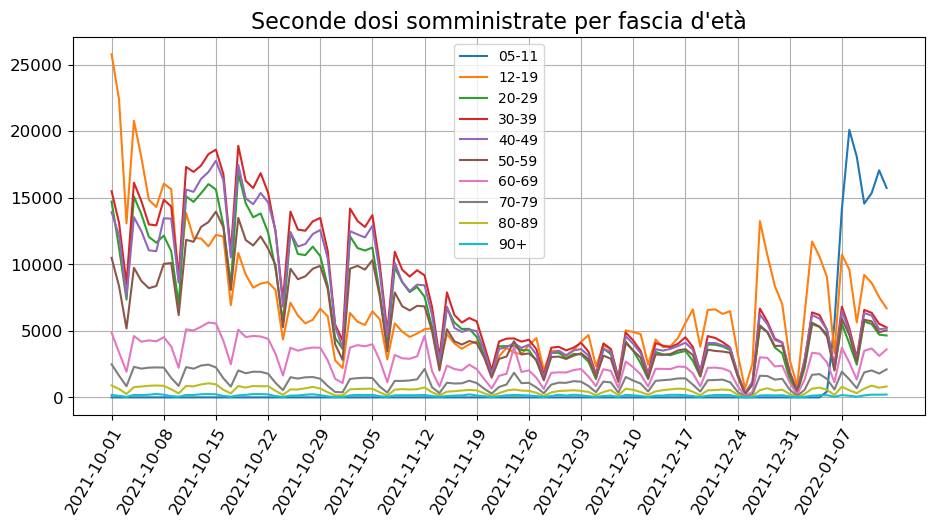

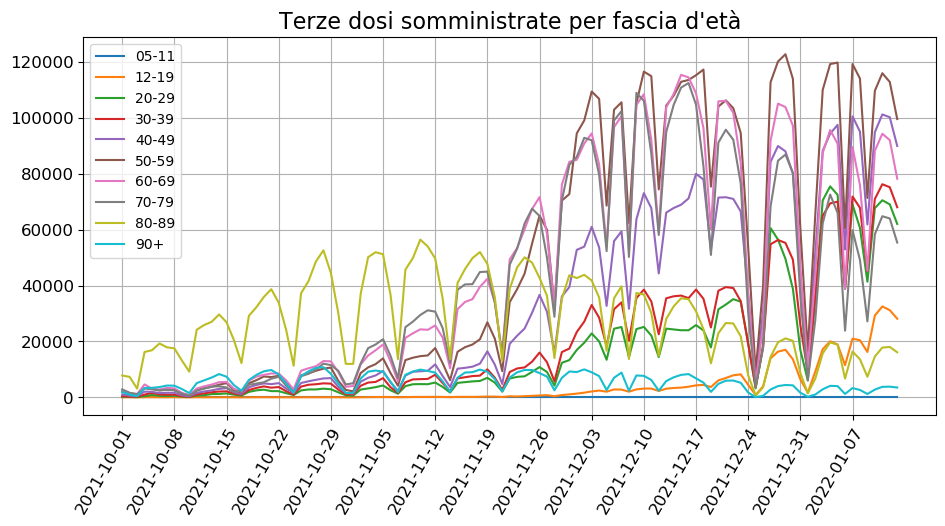

In [50]:
dosi_eta(media=False)

In [51]:
grid = get_grid(keys=["data_somministrazione", "fascia_anagrafica","fornitore"])

In [52]:
df_vax_yyyy_mm_dd_anag_fornitore = grid.merge(df_vax_yyyy_mm_dd_anag_fornitore, on=["data_somministrazione", "fascia_anagrafica","fornitore"],how="left")
df_vax_yyyy_mm_dd_anag_fornitore = df_vax_yyyy_mm_dd_anag_fornitore.fillna(0)

In [53]:
df_vax_yyyy_mm_dd_anag_fornitore[df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica=="05-11"]

data_somministrazione fascia_anagrafica                fornitore  \
0                2020-12-27             05-11                  Janssen   
1                2020-12-27             05-11                  Moderna   
2                2020-12-27             05-11        Pfizer Pediatrico   
3                2020-12-27             05-11          Pfizer/BioNTech   
4                2020-12-27             05-11  Vaxzevria (AstraZeneca)   
...                     ...               ...                      ...   
19100            2022-01-13             05-11                  Janssen   
19101            2022-01-13             05-11                  Moderna   
19102            2022-01-13             05-11        Pfizer Pediatrico   
19103            2022-01-13             05-11          Pfizer/BioNTech   
19104            2022-01-13             05-11  Vaxzevria (AstraZeneca)   

       prima_dose  seconda_dose  terza_dose  pregressa_infezione  \
0             0.0           0.0         0.0                  0.0   
1             0.0           0.0         0.0                  0.0   
2             0.0           0.0         0.0                  0.0   
3             0.0           0.0         0.0                  0.0   
4             0.0           0.0         0.0                  0.0   
...           ...           ...         ...                  ...   
19100         0.0           0.0         0.0                  0.0   
19101         0.0           0.0         0.0                  0.0   
19102     25724.0       15731.0         0.0                 87.0   
19103         0.0           0.0         0.0                  0.0   
19104         0.0           0.0         0.0                  0.0   

       prima_dose_no_guariti  prima_dose_media_7  seconda_dose_media_7  \
0                        0.0            0.000000              0.000000   
1                        0.0            0.000000              0.000000   
2                        0.0            0.000000              0.000000   
3                        0.0            0.000000              0.000000   
4                        0.0            0.000000              0.000000   
...                      ...                 ...                   ...   
19100                    0.0            0.000000              0.000000   
19101                    0.0            0.000000              0.000000   
19102                25637.0        33874.142857          16431.714286   
19103                    0.0            0.000000              0.000000   
19104                    0.0            0.000000              0.000000   

       terza_dose_media_7  
0                     0.0  
1                     0.0  
2                     0.0  
3                     0.0  
4                     0.0  
...                   ...  
19100                 0.0  
19101                 0.0  
19102                 0.0  
19103                 0.0  
19104                 0.0  

[1915 rows x 11 columns]

In [64]:
def plot_anag_fornitore(start_date, media=False):
    for dose in ["prima","seconda","terza"]:
        for fornitore in fornitori:
            plt.figure(dpi=100, figsize=(10,4))
            max_val_0 = 0
            col_idx = 0
            for anag in anagrafiche:
                condizione = (df_vax_yyyy_mm_dd_anag_fornitore.fornitore == fornitore) & (df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica==anag)
                df_plot = df_vax_yyyy_mm_dd_anag_fornitore[condizione]
                df_plot = df_plot[df_plot.data_somministrazione>=start_date]
                Xval = df_plot["data_somministrazione"]
                Yval = df_plot[f"{dose}_dose"]
                Yval_media7 = df_plot[f"{dose}_dose_media_7"]
                if media:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=0.15, color=colors[col_idx])
                    plt.plot(Xval, Yval_media7, label=anag, linewidth=2.0, color=colors[col_idx])
                else:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=1, color=colors[col_idx],label=anag)
                max_val = np.max(Yval)
                col_idx += 1
                if max_val > max_val_0:
                    max_val_0 = max_val
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % 7 == 0]
            plt.xticks(x, rotation=60, 
                       rotation_mode="anchor", 
                       verticalalignment = "top", 
                       horizontalalignment = "right",
                       fontsize=12
                      )
            plt.yticks(fontsize=12)
            plt.grid()
            plt.legend()
            if dose == "prima":
                title = "Prime dosi"
            elif dose == "seconda":
                title = "Seconde dosi"
            else:
                title = "Terze dosi"
            title = f"{title} somministrate per fascia d'età"
            if media:
                title += ", media 7 giorni, "
            title += f" {fornitore}"
            savename = f"{plots_folder}/{dose}_dose_{fornitore.replace('/','_')}_eta"
            if media:
                savename += "_media7"
            savename += ".png"
            plt.title(title, fontsize=16)
            plt.savefig(fname=savename,bbox_inches="tight")

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


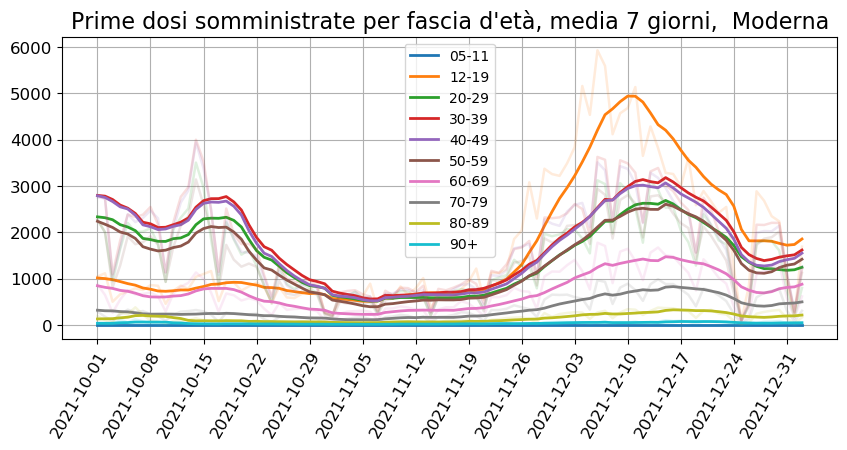

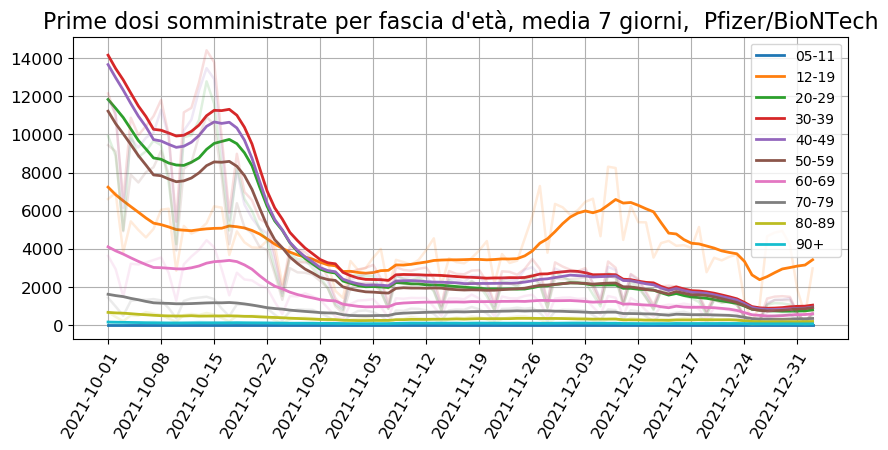

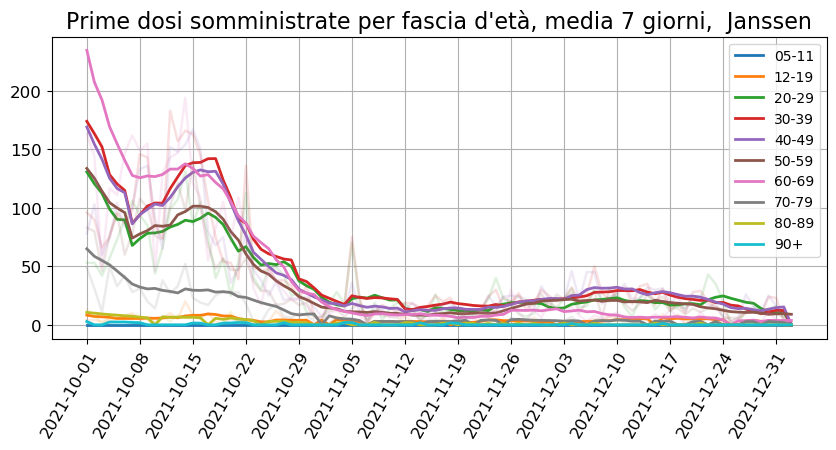

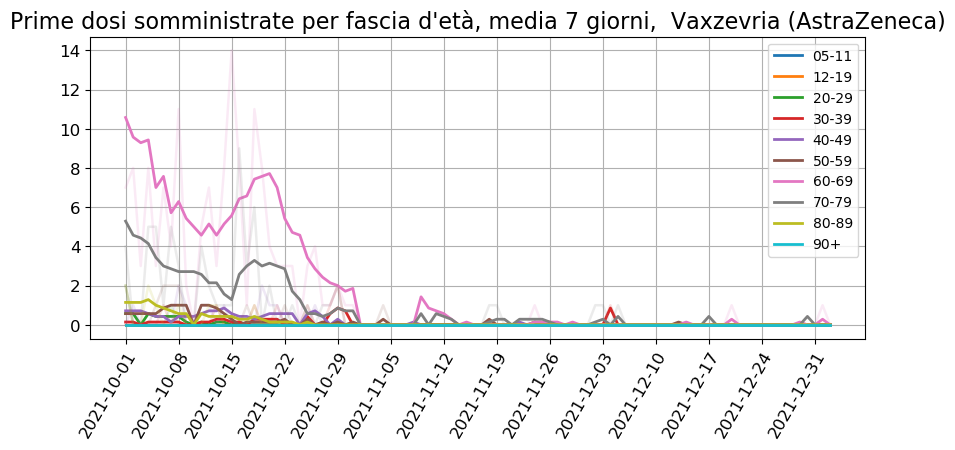

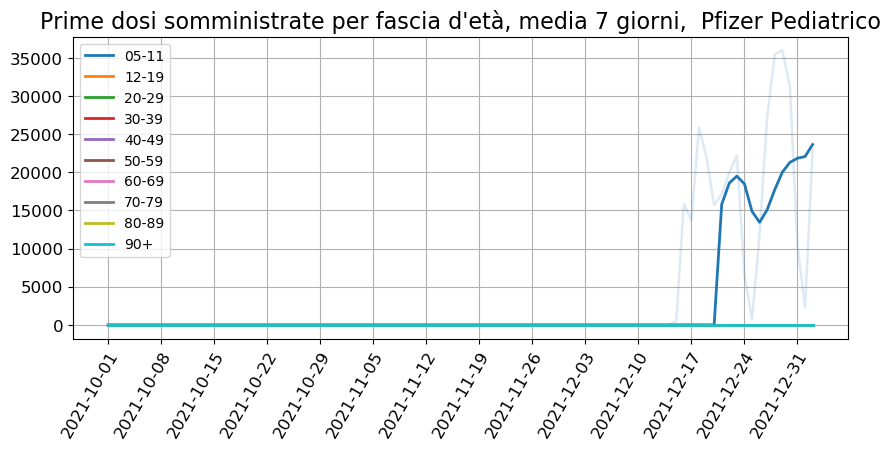

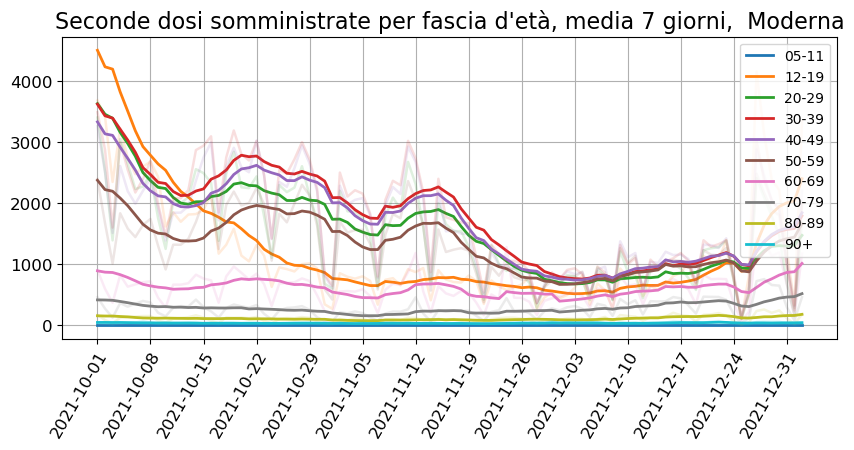

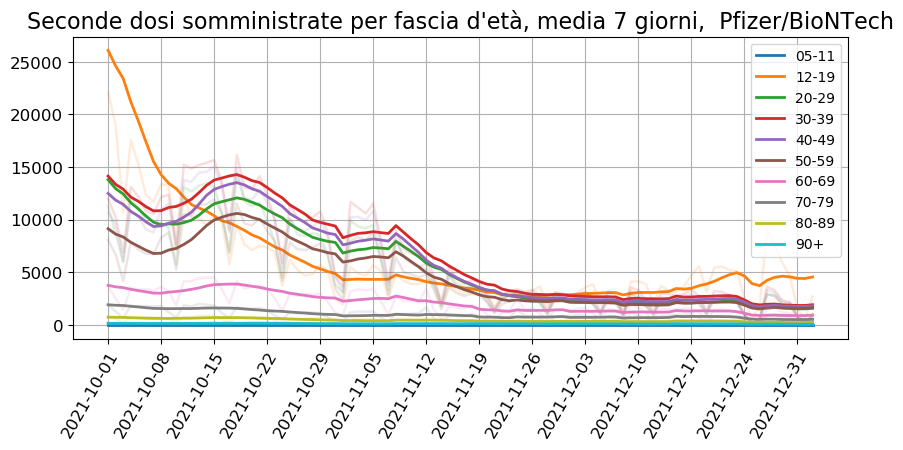

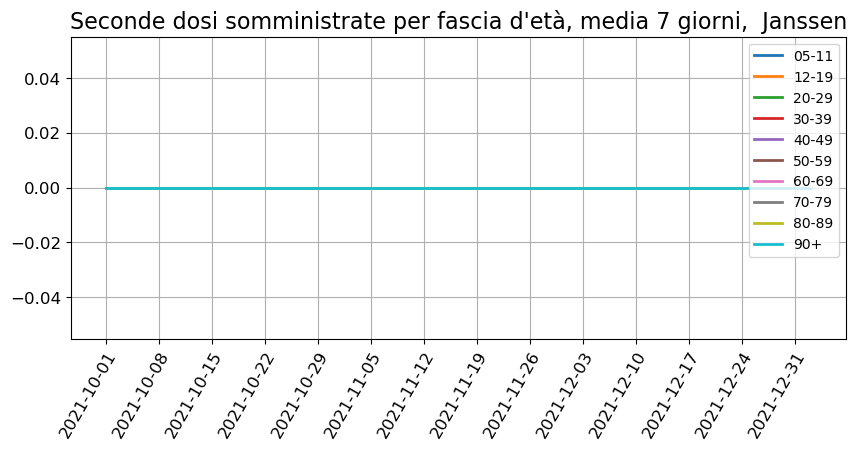

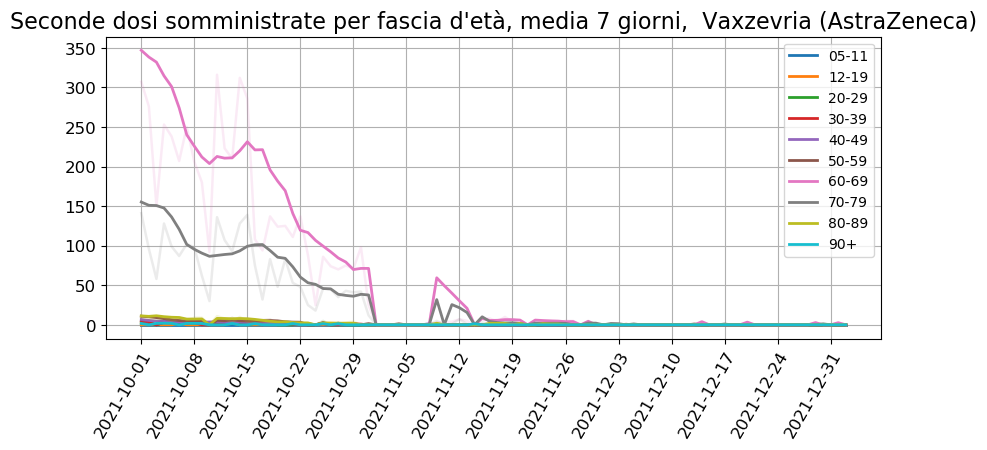

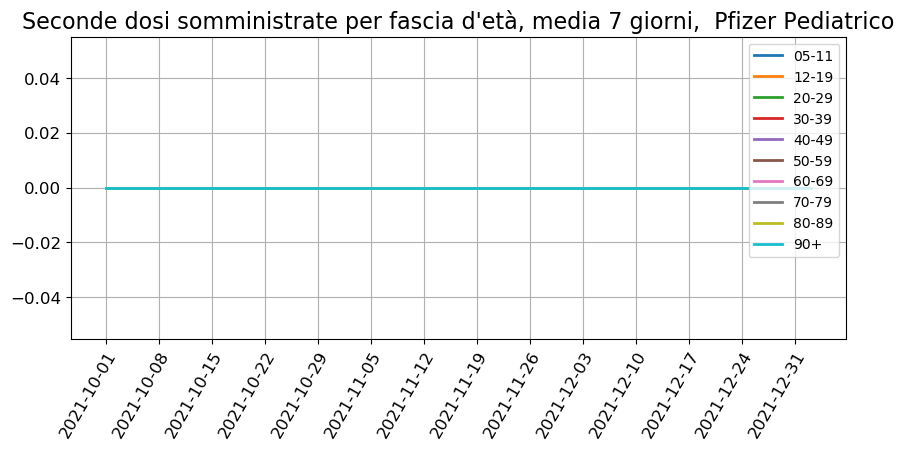

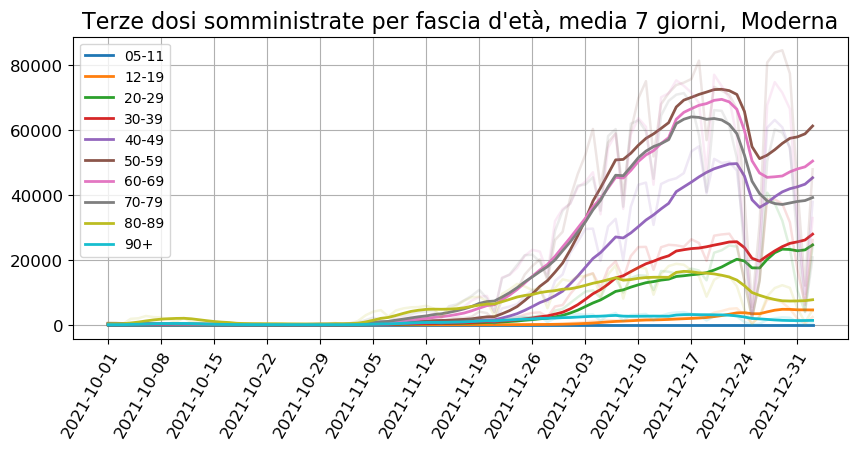

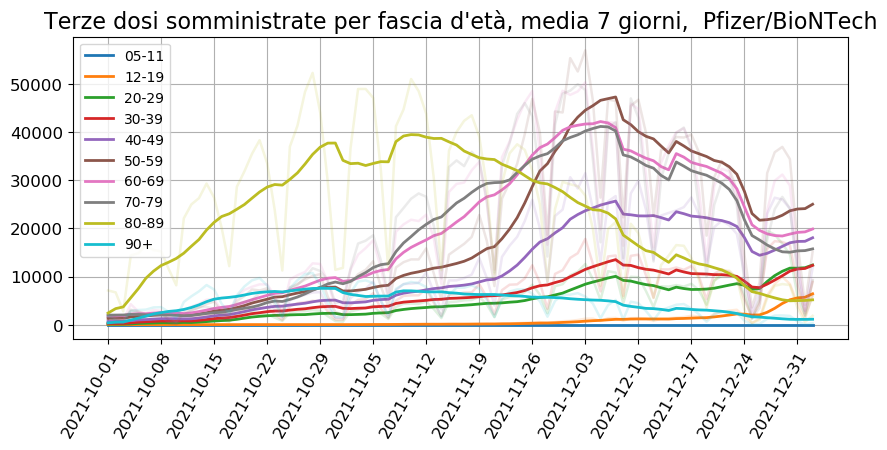

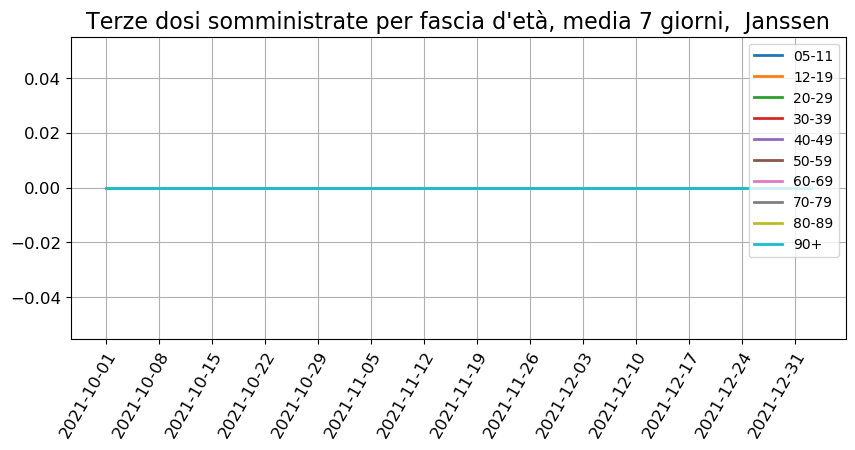

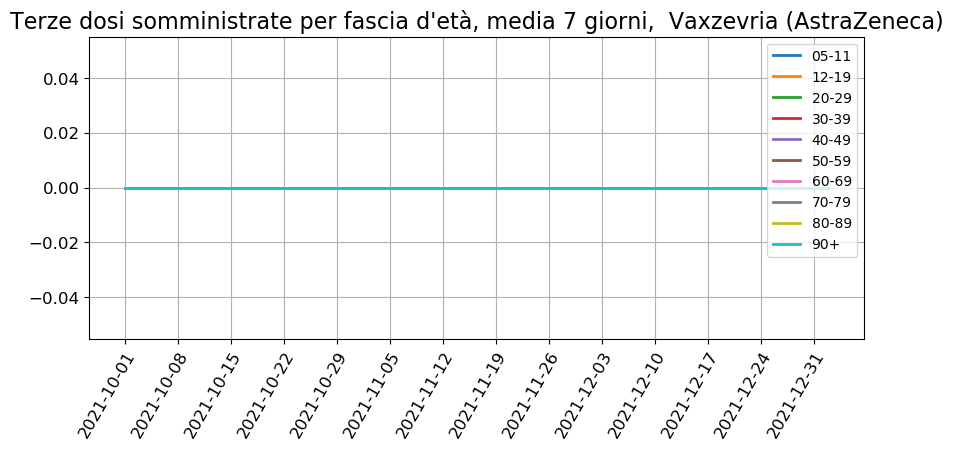

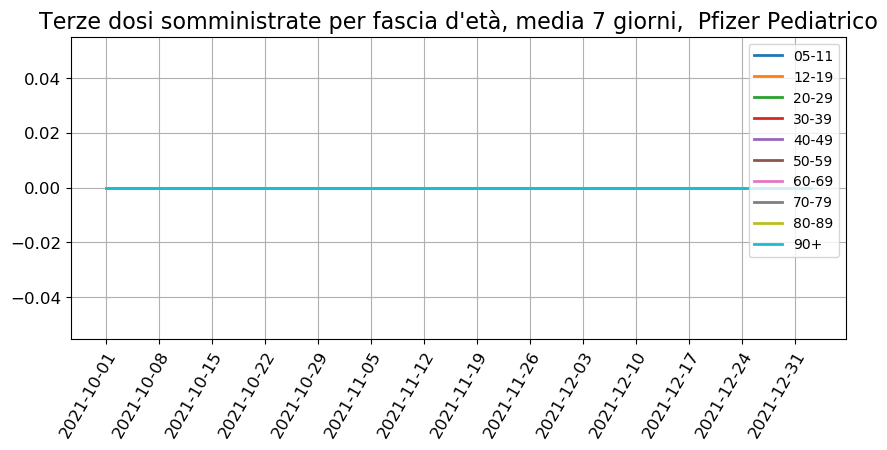

In [65]:
plot_anag_fornitore(start_date="2021-10-01", media=True)

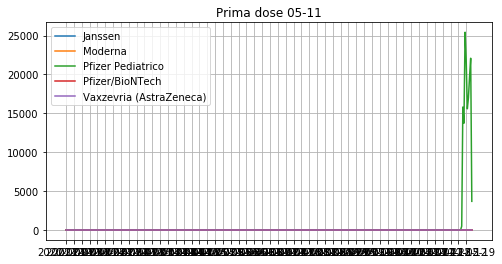

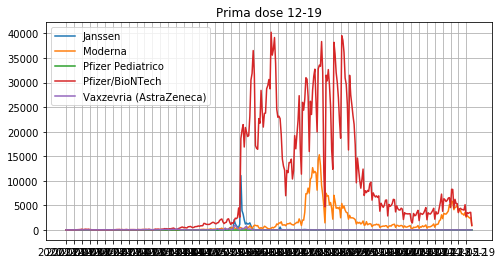

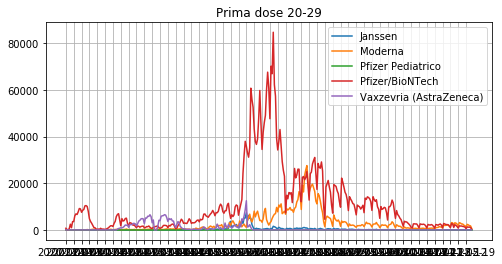

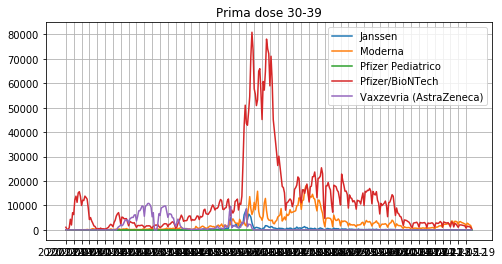

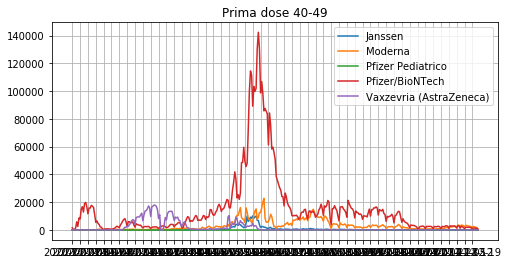

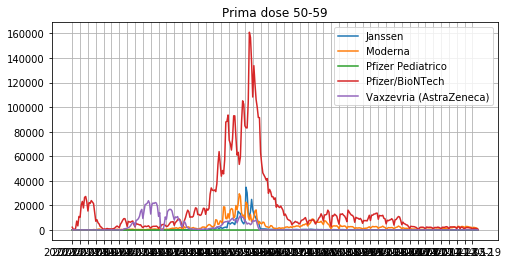

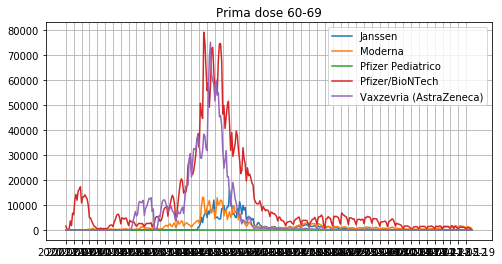

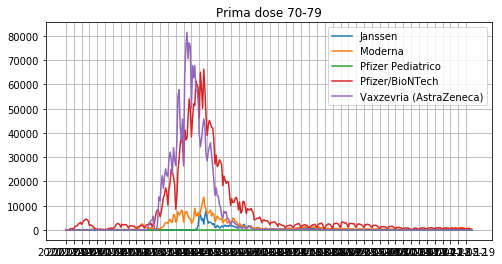

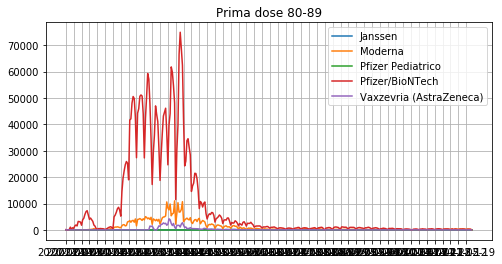

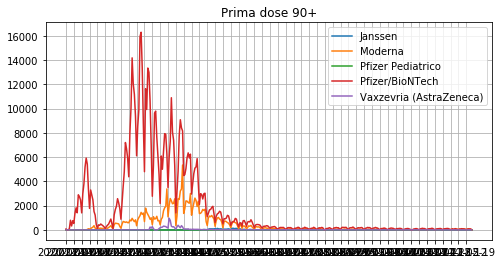

In [139]:
date = df_vax_yyyy_mm_dd_anag_fornitore.data_somministrazione.unique()
for anag in anagrafiche:
    plt.figure(figsize=(8,4))
    df_plt = df_vax_yyyy_mm_dd_anag_fornitore[df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica==anag]
    for brand in fornitori:
        df_plt_brand = df_plt[df_plt.fornitore==brand]
        plt.plot(df_plt_brand["data_somministrazione"], df_plt_brand["prima_dose"], label=brand)
    plt.title(f"Prima dose {anag}")
    
    xticks = [date[i] for i in range(0,len(date)) if i % 7 == 0]
    plt.xticks(xticks)
    plt.grid()
    plt.legend()